# Exploratory Data Analysis - Principal Component Analysis with Palette Data

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.gridspec import GridSpec
from matplotlib import colors as mcolors
import seaborn as sn
import ipywidgets as widgets
from ipywidgets import Button, Checkbox, HBox, VBox
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  

## Helper Functions

The standard <code>read_data()</code> function seen throughout the project. designed to simplify and standardize the data reading process. <br/>In addition the _Global_ variables associated with its function are defined along with the relitive paths to the data files.<br/>__NOTE:__ in a business environment this function would be placed into a pythin module and imported. Here it is included into the notebook to provide full transparency. 

In [2]:
# required modules
import numpy as np
import pandas as pd
import sqlite3
from sklearn import preprocessing
import colorsys

# groups
COLOURS      = 10
PALETTES     = 11
LRG_PALETTES = 12
IMAGE        = 13
TILES        = 14

# sets
TRAIN        = 20
TEST         = 21
VALIDATE     = 22

# targets
ARTIST       = 30
GENRE        = 31
STYLE        = 32

# array
DATA         = 40
CATAGORY     = 41
CATAGORY_NUM = 42
IMAGE_TAG    = 43
TILE_INDEX   = 44

# colour systems
HLS          = 50
RGB          = 51
RAW          = 52

# an overly complicated method of defining the data file path
data_file  = {COLOURS      : {TRAIN    : {ARTIST : "./data/colour_sets/artist_train_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_train_colours.npz",
                                          STYLE  : "./data/colour_sets/style_train_colours.npz"},
                              TEST     : {ARTIST : "./data/colour_sets/artist_test_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_test_colours.npz",
                                          STYLE  : "./data/colour_sets/style_test_colours.npz"} ,
                              VALIDATE : {ARTIST : "./data/colour_sets/artist_validation_colours.npz",
                                          GENRE  : "./data/colour_sets/genre_validation_colours.npz",
                                          STYLE  : "./data/colour_sets/style_validation_colours.npz"}},
              PALETTES     : {TRAIN    : {ARTIST : "./data/palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/palette_sets/style_validation_palettes.npz"}},
              LRG_PALETTES : {TRAIN    : {ARTIST : "./data/large_palette_sets/artist_train_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_train_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_train_palettes.npz"} ,
                              TEST     : {ARTIST : "./data/large_palette_sets/artist_test_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_test_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_test_palettes.npz"} ,
                              VALIDATE : {ARTIST : "./data/large_palette_sets/artist_validation_palettes.npz",
                                          GENRE  : "./data/large_palette_sets/genre_validation_palettes.npz",
                                          STYLE  : "./data/large_palette_sets/style_validation_palettes.npz"}},
              IMAGE        : {TRAIN    : {ARTIST : "./data/full_image_feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/full_image_feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/full_image_feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/full_image_feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/full_image_feature_sets/style_validation_features.npz"}},
              TILES        : {TRAIN    : {ARTIST : "./data/feature_sets/artist_train_features.npz",
                                          GENRE  : "./data/feature_sets/genre_train_features.npz",
                                          STYLE  : "./data/feature_sets/style_train_features.npz"} ,
                              TEST     : {ARTIST : "./data/feature_sets/artist_test_features.npz",
                                          GENRE  : "./data/feature_sets/genre_test_features.npz",
                                          STYLE  : "./data/feature_sets/style_test_features.npz"} ,
                              VALIDATE : {ARTIST : "./data/feature_sets/artist_validation_features.npz",
                                          GENRE  : "./data/feature_sets/genre_validation_features.npz",
                                          STYLE  : "./data/feature_sets/style_validation_features.npz"}}}

# Create a DB connection between python and the file system
conn = sqlite3.connect("./data/database/artist.db")

# the fuction that provides a standard data read method
def read_data(data_group, data_set, data_target, data_type, colour_system = RGB):
    
    # read the data file
    data = np.load(data_file[data_group][data_set][data_target], allow_pickle=True)

    # if tile index is requested
    if   data_type    == TILE_INDEX:
        # when group is tiles, return the tile indexes
        if data_group == TILES:
            return pd.DataFrame(data["arr_3"], columns = {"tile_index"})
        # otherwise, just return an emtpy dataset
        else:
            return pd.DataFrame(columns = {"tile_index"})
    # if image tags are requested
    elif data_type == IMAGE_TAG:
        return pd.DataFrame(data["arr_2"], columns = {"image_tag"})
    # if catagory data is requested
    elif data_type == CATAGORY:
        return pd.DataFrame(data["arr_1"], columns = {"catagory"})
    # if catagory_num is requested
    elif data_type == CATAGORY_NUM:
        # select data for the appropriate lookup table
        if   data_target == ARTIST: 
            query_string = "SELECT ID, NAME  AS VALUE FROM ARTIST"
        elif data_target == GENRE:
            query_string = "SELECT ID, GENRE AS VALUE FROM GENRE"
        else:
            query_string = "SELECT ID, STYLE AS VALUE FROM STYLE" 
        # build the lookup table
        lookup = pd.read_sql_query(query_string, conn)
        # get the catagory data
        data   = pd.DataFrame(data["arr_1"], columns = {"catagory"})
        # convert the catagory text labels to numeric catagory ids
        return pd.DataFrame(data["catagory"].apply(lambda x: lookup[lookup["VALUE"] == x]["id"].values[0]))
    # data requested
    elif data_group == COLOURS:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[1] * data["arr_0"].shape[2])))
    elif data_group == PALETTES or data_group == LRG_PALETTES:

        # extract the colour data
        colour_data = data["arr_0"]
        
        # find the datas dimensions
        records, _, palette_length, palette_layers = np.shape(colour_data)
        
        # reshape
        colour_data = colour_data.reshape(records * palette_length, palette_layers)
        
        # convert to a dataframe
        colour_data_df = pd.DataFrame(colour_data, columns =["r","g","b"])
        
        # process the data with different colour systems
        
        # hue, luminance, saturation
        if colour_system == HLS:
            
            # define a dataframe to hold the hls values
            hls_data_df = pd.DataFrame(columns =["h","l","s"])

            # loop through each record
            for row in colour_data_df.iterrows():
                
                # extract the r,g,b values and devide them by 255 ready to convert
                r, g, b = row[1].values/255

                # convert the values and add them to the dataframe
                hls_data_df.loc[len(hls_data_df)] = colorsys.rgb_to_hls(r, g, b)
            
            # create datasets and normalize
            hue        = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["h"]).reshape(records, palette_length)))
            luminance  = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["l"]).reshape(records, palette_length)))
            saturation = pd.DataFrame(preprocessing.normalize(np.array(hls_data_df["s"]).reshape(records, palette_length)))  
            
            # return values
            return hue, luminance, saturation
            
        # red, green, blue unnormalized
        elif colour_system == RAW:
            red   = pd.DataFrame(np.array(colour_data_df["r"]).reshape(records, palette_length))
            green = pd.DataFrame(np.array(colour_data_df["g"]).reshape(records, palette_length))
            blue  = pd.DataFrame(np.array(colour_data_df["b"]).reshape(records, palette_length))
            
            # return values
            return red, green, blue            
            
        # red, green, blue normalized- (default)
        else:
    
            # create datasets and normalize
            red   = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["r"]).reshape(records, palette_length)))
            green = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["g"]).reshape(records, palette_length)))
            blue  = pd.DataFrame(preprocessing.normalize(np.array(colour_data_df["b"]).reshape(records, palette_length)))
            
            # return values
            return red, green, blue

    elif data_group == IMAGE:
        # reshape the data and normalize
        return pd.DataFrame(preprocessing.normalize(data["arr_0"].reshape(data["arr_0"].shape[0],data["arr_0"].shape[2])))
    else:
        # normalize the data
        return pd.DataFrame(preprocessing.normalize(data["arr_0"])) 

The Function <code>read_filtered_data_by_artist()</code> requires a data group from __COLOURS, PALETTES, LRG_PALETTES, IMAGE__ or __TILES__, a data set from __TRAIN, TEST__ or __VALIDATION__ and an artists name. A filtered data set matching these parameters is then returned

In [3]:
def read_filtered_data_by_artist(data_group, data_set, artist):
    
    # read all matching data
    data = read_data(data_group, data_set, ARTIST , DATA)
    
    # generate a filter that is only true for the artist 
    data_filter = read_data(data_group, data_set, ARTIST, CATAGORY) == artist
    
    # apply the filter to the data and return
    return data[data_filter["catagory"]]

The Function <code>read_tile_data_by_image_tag()</code> requires a data group from __COLOURS, PALETTES, LRG_PALETTES, IMAGE__ or __TILES__, a data set from __TRAIN, TEST__ or __VALIDATION__ and an __IMAGE_TAG__. A filtered data set matching these parameters is then returned

In [4]:
def read_tile_data_by_image_tag(data_set, data_target, image_tag):
    
    # read all matching data
    data = read_data(TILES, data_set, data_target, DATA)
    
    # generate a filter that is only true for the image_tag 
    data_filter = read_data(TILES, data_set, data_target, IMAGE_TAG ) == image_tag
    
    # apply the filter to the data and return
    return data[data_filter["image_tag"]]

The Function <code>get_image_for_image_tag()</code> takes an __IMAGE_TAG__ and returns the content of the corresponding image file.

In [5]:
# required modules
import matplotlib.pyplot as plt
from PIL import Image

def get_image_for_image_tag(image_tag):
    
    # construct path to images
    data_file_path  = "./data/"
    image_file_path = "".join([data_file_path, "images/"]) 
    image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])
    
    # return the opened image
    return Image.open(image_path)

The Functions <code>red_data_only()</code>, <code>green_data_only()</code> & <code>blue_data_only()</code> extract just their relivant colour data from a colour data set and return it.

In [6]:
def red_data_only(data):
    
    # identify columns holding red data
    red_columns = range(0,len(data.columns),3)
    
    # extarct to columns
    red         = data[red_columns]
    
    # set the column names
    red.columns = range(0, len(data.columns) // 3)

    # return only the columns of red data
    return red

def green_data_only(data):
    
    # identify columns holding green data
    green_columns = range(1,len(data.columns),3)
    
    # extarct to columns
    green         = data[green_columns]
    
    # set the column names
    green.columns = range(0, len(data.columns) // 3)

    # return only the columns of green data
    return green

def blue_data_only(data):
    
    # identify columns holding blue data
    blue_columns = range(2,len(data.columns),3)
    
    # extarct to columns
    blue         = data[blue_columns]
    
    # set the column names
    blue.columns = range(0, len(data.columns) // 3)

    # return only the columns of blue data
    return blue

The <code>get_colours()</code> function provides a list of colours the length of the value <code>no_of_colours</code>. This can be useful for consisten colours when used across multiple plots. 

In [ ]:
# required modules
import random

# define colours used 
def get_colours(no_of_colours):
    
    # consistent randomness
    random.seed(42)
    
    # colour list
    colours = []

    # generate colours
    for i in range(no_of_colours):
        colours.append("#%06X" % random.randint(0, 0xFFFFFF))
    
    # return the colour list
    return colours

Generate sorted lists of _Artists, Genres_ & _Styles_. These are used in a variety of situations. These functions ensure that the lists are always defined in the same order.

In [7]:
# define data lists
artists = list(set(read_data(COLOURS, TRAIN, ARTIST, CATAGORY)["catagory"]))
styles  = list(set(read_data(COLOURS, TRAIN, STYLE,  CATAGORY)["catagory"]))
genres  = list(set(read_data(COLOURS, TRAIN, GENRE,  CATAGORY)["catagory"]))

# sort the lists
artists.sort()
styles.sort()
genres.sort()

The Function <code>create_pca_2_component_dataset()</code> with Training and Target data provided the data is fitted and the first two __PCA__ components are identified. They are linked to their Catagory values (_Either an Artist name, Genre_ or _Style_) and returned.

In [8]:
def create_pca_2_component_dataset(X_data, y_data, catagory_data):
    # Create PCA transformer
    pca = PCA(n_components=None)

    # Apply PCA
    pca.fit(X_data, y_data);

    # Project data onto the first two components
    X_2d = pca.transform(X_data)

    # convert first 2 components to a dataframe and rename
    df_X2d = pd.DataFrame(X_2d)[[1,2]]
    df_X2d.columns =["1st_component", "2nd_component"]

    # add catagories to the data as numeric values
    df_X2d["label"] = catagory_data["catagory"]
    
    return df_X2d

The Function <code>create_pca_2_component_dataset()</code> with Training and Target data provided the data is fitted and the first three __PCA__ components are identified. They are linked to their Catagory values (_Either an Artist name, Genre_ or _Style_) and returned.

In [9]:
def create_pca_3_component_dataset(X_data, y_data, catagory_data):
    # Create PCA transformer
    pca = PCA(n_components=None)

    # Apply PCA
    pca.fit(X_data, y_data);

    # Project data onto the first two components
    X_3d = pca.transform(X_data)

    # convert first 3 components to a dataframe and rename
    df_X3d = pd.DataFrame(X_3d)[[1,2,3]]
    
    df_X3d.columns =["1st_component", "2nd_component", "3rd_component"]

    # add catagories to the data as numeric values
    df_X3d["label"] = catagory_data["catagory"]
    
    return df_X3d

The Function <code>grid_plot_target_components()</code> provides the plotting functionality to plot the individual visualizations of the function <code>grid_target_components()</code>. 

In [ ]:
# prepare plot for grid figure
def grid_plot_target_components(pca_dataset, ax, target, colour, subtraction):
    
    data     = pca_dataset[pca_dataset['label'] == target]
    sub_data = pca_dataset[pca_dataset['label'] != target]
    
    # construct plot of targets data
    ax.scatter(data["1st_component"],
               data["2nd_component"], 
               s     = 60, 
               alpha = .3 + (subtraction * 0.7), 
               c     = colour)
    
    # remove other targets data overlaps
    if subtraction:
        ax.scatter(sub_data["1st_component"],
                   sub_data["2nd_component"], 
                   s     = 60, 
                   alpha = 1, 
                   c     = "white")    
    
    # prepare plots other visuals
    ax.set_xlabel("1st Component", 
                  fontsize = 10)
    ax.set_ylabel("2nd Component", 
                  fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(target, 
                 fontsize=12)

The Function <code>grid_target_components()</code> generates a grid to display plots and then calls the function <code>grid_plot_target_components()</code> to populate each of the grid cells.

In [10]:
# prepare grid figure 
def grid_target_components(pca_dataset, targets, title, subtraction = False):
    
    plots_per_grid_row = 5
    
    colours = get_colours(len(targets))
    
    # calculate the number of grid rows
    if len(targets) % plots_per_grid_row == 0:
        grid_rows = len(targets) / plots_per_grid_row
    else:
        grid_rows = int(len(targets) / plots_per_grid_row) + 1

    # define the figure grid
    fig, axs = plt.subplots(nrows = grid_rows, ncols = plots_per_grid_row, constrained_layout = False, figsize = (25, grid_rows * 5))

    # display the title
    fig.suptitle(title, fontsize=16, y = .93)

    # count the iterations
    counter = 0

    # loop through each figure grid location
    for ax in axs.flat:
    
        # when data is available create a plot
        try:
            grid_plot_target_components(pca_dataset, ax, targets[counter], colours[counter], subtraction)
        # when no data skip plot
        except:
            pass
    
        #iterate the counter
        counter += 1

The Function <code>plot_3d_target_components()</code> generates a 3D interactive plot of the first three PCA components using the functionality of the <code>ipywidgets</code> module. This was introduced here as an experimant.<br/>__NOTE:__ you must have the Jupyter ipywidgets plug-in configured for your environment for this to function correctly.

In [11]:
def plot_3d_target_components (data, target):
    
    # To prevent automatic figure display when execution of the cell ends
    %config InlineBackend.close_figures = False 

    # create the colour set to be used for the plot
    colours = get_colours(len(target))

    # do not plot anything until required
    plt.ioff()
    
    # define the figure
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(projection = "3d")

    # define widgits
    radio_btns        = widgets.RadioButtons(options=["Red", "Green", "Blue", "Hue", "Luminance", "Saturation"], value = "Red", description = "Channel:")
    checkboxes        = [widgets.Checkbox(value = False, description = label) for label in target]
    artist_checkboxes = widgets.VBox(children   = checkboxes)
    azimut_slider     = widgets.IntSlider(description = "azimut",  value   = 30)
    replot_btn        = widgets.Button(   description = "Replot")
    out               = widgets.Output()

    # layout for the checkboxes
    box_layout        = widgets.Layout(display = "flex", flex_flow = "column", align_items = "center")
    
    # arrange widgit boxes
    left_box          = VBox([out])
    right_box         = VBox([artist_checkboxes, radio_btns, azimut_slider, replot_btn],layout = box_layout)
    
    # show widgits
    display(HBox([left_box, right_box]))

    # when the replot button is clicked draw the plot with new data / azimut  
    def replot_btn_click(b):
        
        # modify the ax in the parent function
        global ax
        ax = fig.add_subplot(projection = "3d")
        
        printout = ""
        
        # if called from a button press
        if b:
            
            plot_data = data[radio_btns.value]
    
            # list of selected check boxes
            selected_checkboxes = []
            
            for i in range(0, len(checkboxes)):
                if checkboxes[i].value == True:
                    selected_checkboxes = selected_checkboxes + [checkboxes[i].description]

            printout = selected_checkboxes
            
            # add data points for each selected checkbox
            for checkbox in selected_checkboxes:
                checkbox_plot_data = plot_data[plot_data["label"] == checkbox]
                xs = checkbox_plot_data["1st_component"]
                ys = checkbox_plot_data["2nd_component"]
                zs = checkbox_plot_data["3rd_component"]
                
                # add to plot
                ax.scatter(xs, ys, zs, c = colours[target.index(checkbox)])
            
        # when called without a button press
        else:
            # show an empty plot
            ax.scatter(None, None)
           
        # show the plot title
        ax.set_title("Visualization of the Colour Features Using the First Three PCA Components")
            
        # generate the output
        with out:
            clear_output(wait = True)
            ax.view_init(elev = 10, azim = azimut_slider.value)
            display(ax.figure)                       
   
    # check for events       
    replot_btn.on_click(replot_btn_click)

    # show an empty plot
    replot_btn_click(None)

The Function <code>create_pca_scree_plot()</code> generates a Scree plot for the 3 channel data set (_either_ ___R, G, B___ _or_ ___H, L, S___).

In [12]:
def create_pca_scree_plot(X_data, y_data, colour_system = RGB):
    
    if colour_system == HLS:
        colours =["palegoldenrod","darkkhaki","lightgrey","slategrey","mediumslateblue","indigo"]
    else:
        colours =["salmon","red","palegreen","green","cornflowerblue","navy"]
    
    X_0, X_1, X_2 = X_data
    
    # Create PCA transformer
    pca_0 = PCA(n_components = None)
    pca_1 = PCA(n_components = None)
    pca_2 = PCA(n_components = None)

    # Apply PCA
    pca_0.fit(X_0, y_data);
    pca_1.fit(X_1, y_data);
    pca_2.fit(X_2, y_data);

    # define the figure
    fig = plt.figure(figsize=(30,7))
    
    values_0 = np.arange(pca_0.n_components_) + 1
    values_1 = np.arange(pca_1.n_components_) + 1
    values_2 = np.arange(pca_2.n_components_) + 1
    
    plt.plot(values_0, pca_0.explained_variance_ratio_, '-', linewidth = 2, c = colours[0])
    plt.plot(values_0, pca_0.explained_variance_ratio_, 'o', linewidth = 2, c = colours[1])
    
    plt.plot(values_1, pca_1.explained_variance_ratio_, '-', linewidth = 2, c = colours[2])
    plt.plot(values_1, pca_1.explained_variance_ratio_, 'o', linewidth = 2, c = colours[3])
    
    plt.plot(values_2, pca_2.explained_variance_ratio_, '-', linewidth = 2, c = colours[4])
    plt.plot(values_2, pca_2.explained_variance_ratio_, 'o', linewidth = 2, c = colours[5])
    
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.show()

## Display a Scree Plot for the Colours Data using the __R, G, B__ Colour System for Artists

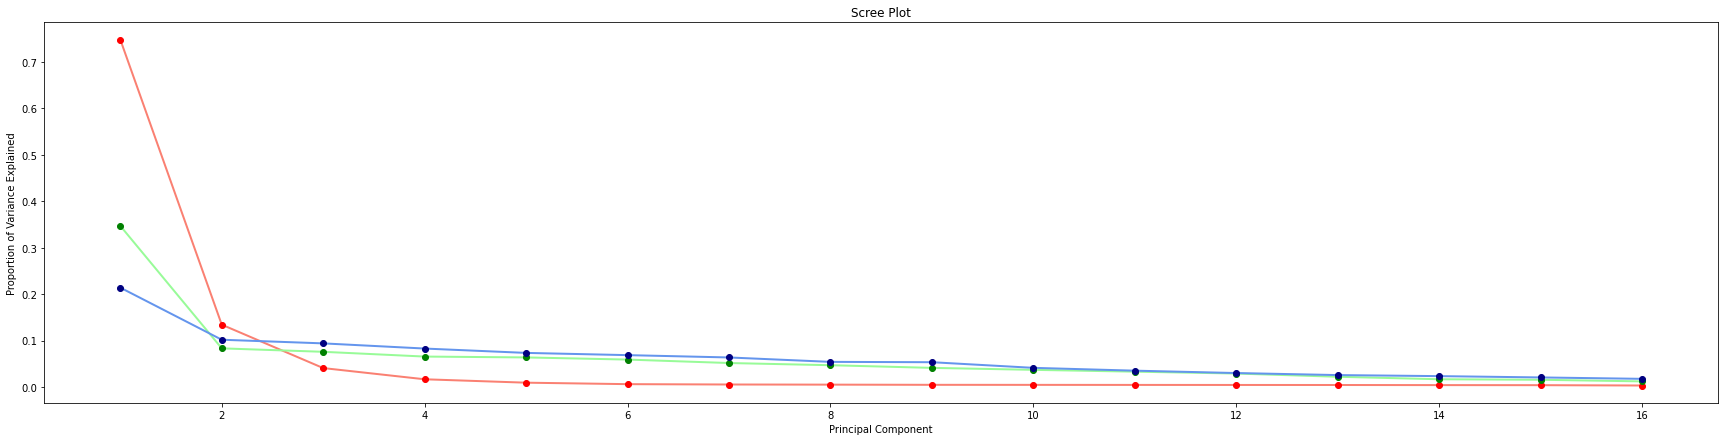

In [13]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, ARTIST, DATA), read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM))

## Display a Scree Plot for the Colours Data using the __H, L, S__ Colour System for Artists

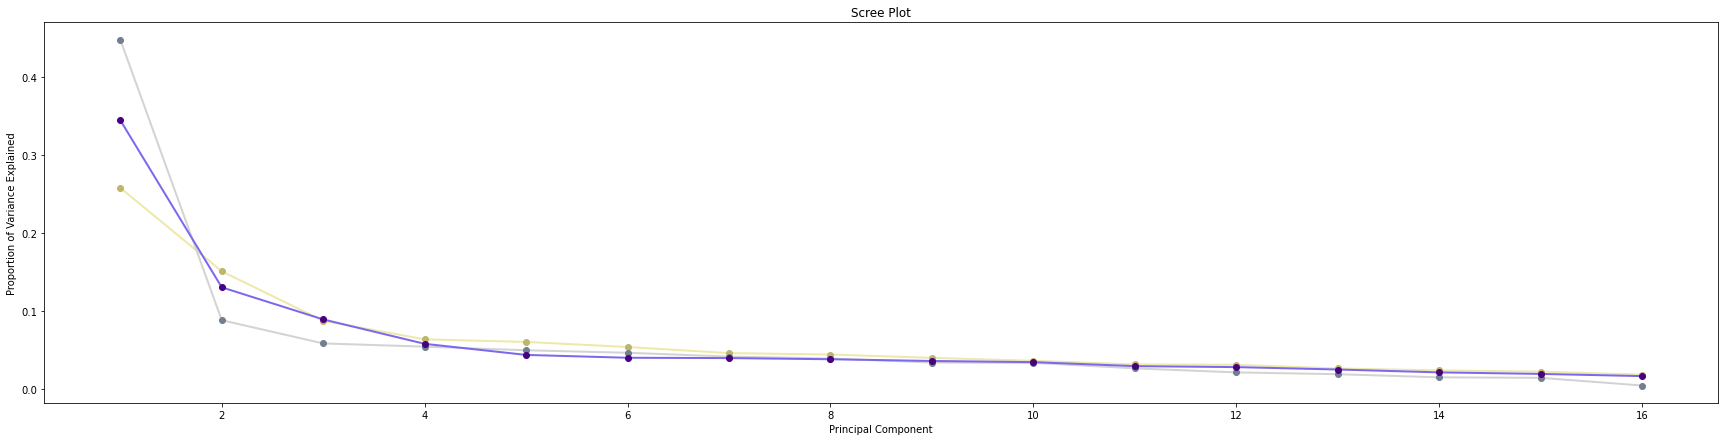

In [14]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, ARTIST, DATA, HLS), read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), HLS)

## Plot the First 2 __R, G, B__  Components of each Artist

In [15]:
# get the colou
artist_red_data, artist_blue_data, artist_green_data = read_data(PALETTES, TRAIN, ARTIST, DATA)

In [16]:
# create colour pcs_datasets
pca_artist_r_dataset = create_pca_2_component_dataset(artist_red_data,   read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))
pca_artist_g_dataset = create_pca_2_component_dataset(artist_green_data, read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))
pca_artist_b_dataset = create_pca_2_component_dataset(artist_blue_data,  read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))

# populate layer column
pca_artist_r_dataset["layer"] = "Red"
pca_artist_g_dataset["layer"] = "Green"
pca_artist_b_dataset["layer"] = "Blue"

# construct the plot dataset
plot_data = pca_artist_r_dataset
plot_data = plot_data.append(pca_artist_g_dataset)
plot_data = plot_data.append(pca_artist_b_dataset)

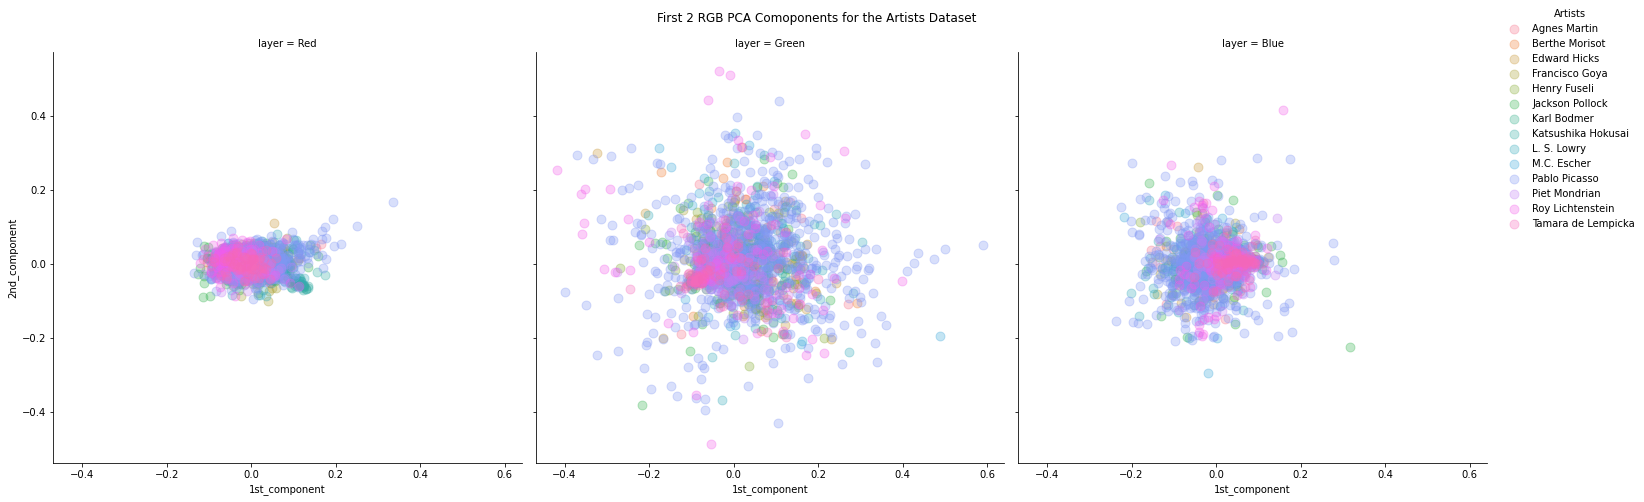

In [17]:
# combined artists pcs plots for r, g & b
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = artists, title = "Artists")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 RGB PCA Comoponents for the Artists Dataset')

# view the plots
plt.show()

## Plot the First 2 __H, L, S__  Components of each Artist

In [18]:
# get the colour data
artist_hue_data, artist_luminance_data, artist_saturation_data = read_data(PALETTES, TRAIN, ARTIST, DATA, HLS)

In [19]:
# create colour pcs_datasets
pca_artist_h_dataset = create_pca_2_component_dataset(artist_hue_data,        read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))
pca_artist_l_dataset = create_pca_2_component_dataset(artist_luminance_data,  read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))
pca_artist_s_dataset = create_pca_2_component_dataset(artist_saturation_data, read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))

# populate layer column
pca_artist_h_dataset["layer"] = "Hue"
pca_artist_l_dataset["layer"] = "Luminance"
pca_artist_s_dataset["layer"] = "Saturation"

# construct the plot dataset
plot_data = pca_artist_h_dataset
plot_data = plot_data.append(pca_artist_l_dataset)
plot_data = plot_data.append(pca_artist_s_dataset)

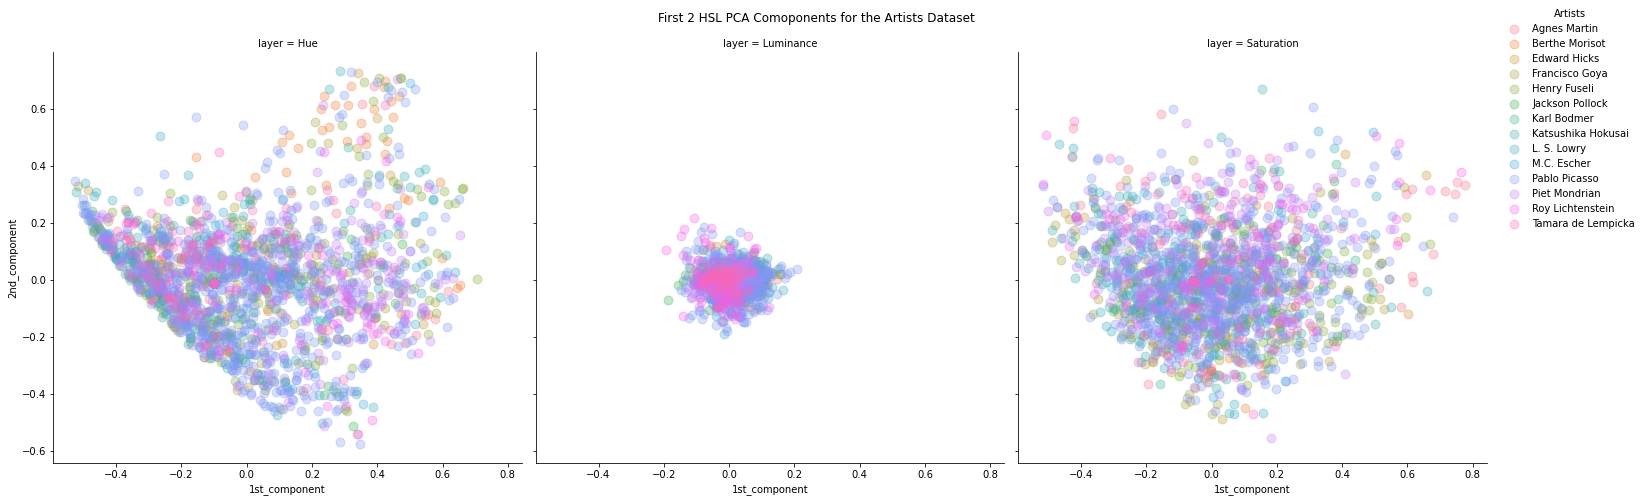

In [20]:
# combined artists pcs plots for h, l & s
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = artists, title = "Artists")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 HSL PCA Comoponents for the Artists Dataset')

# view the plots
plt.show()

That is a little hard to read. So, let´s try viewing the data by individual Artists. 

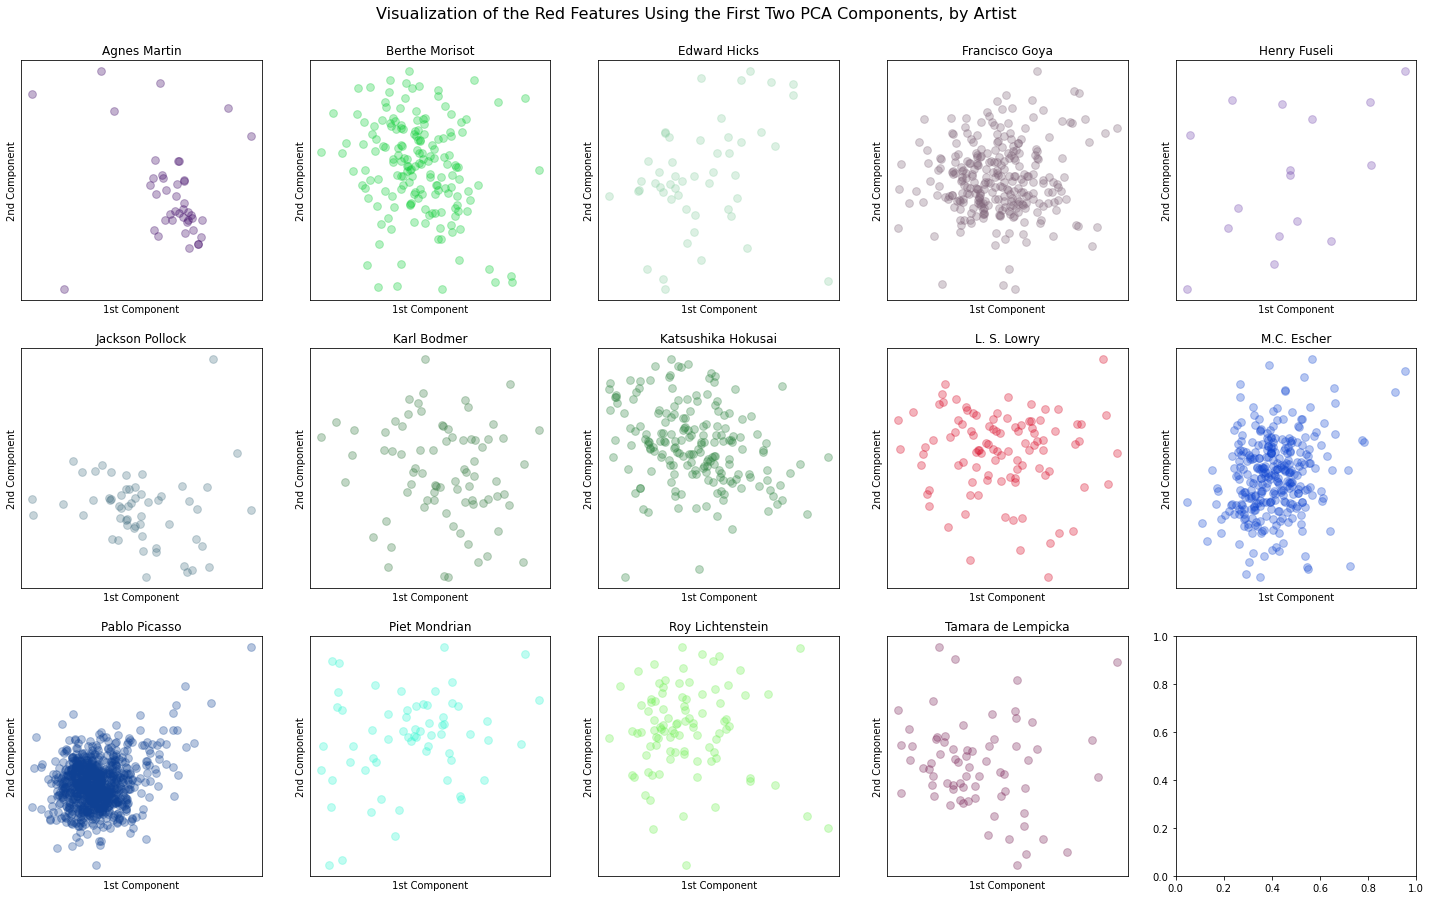

In [21]:
grid_target_components(pca_artist_r_dataset, artists, "Visualization of the Red Features Using the First Two PCA Components, by Artist")

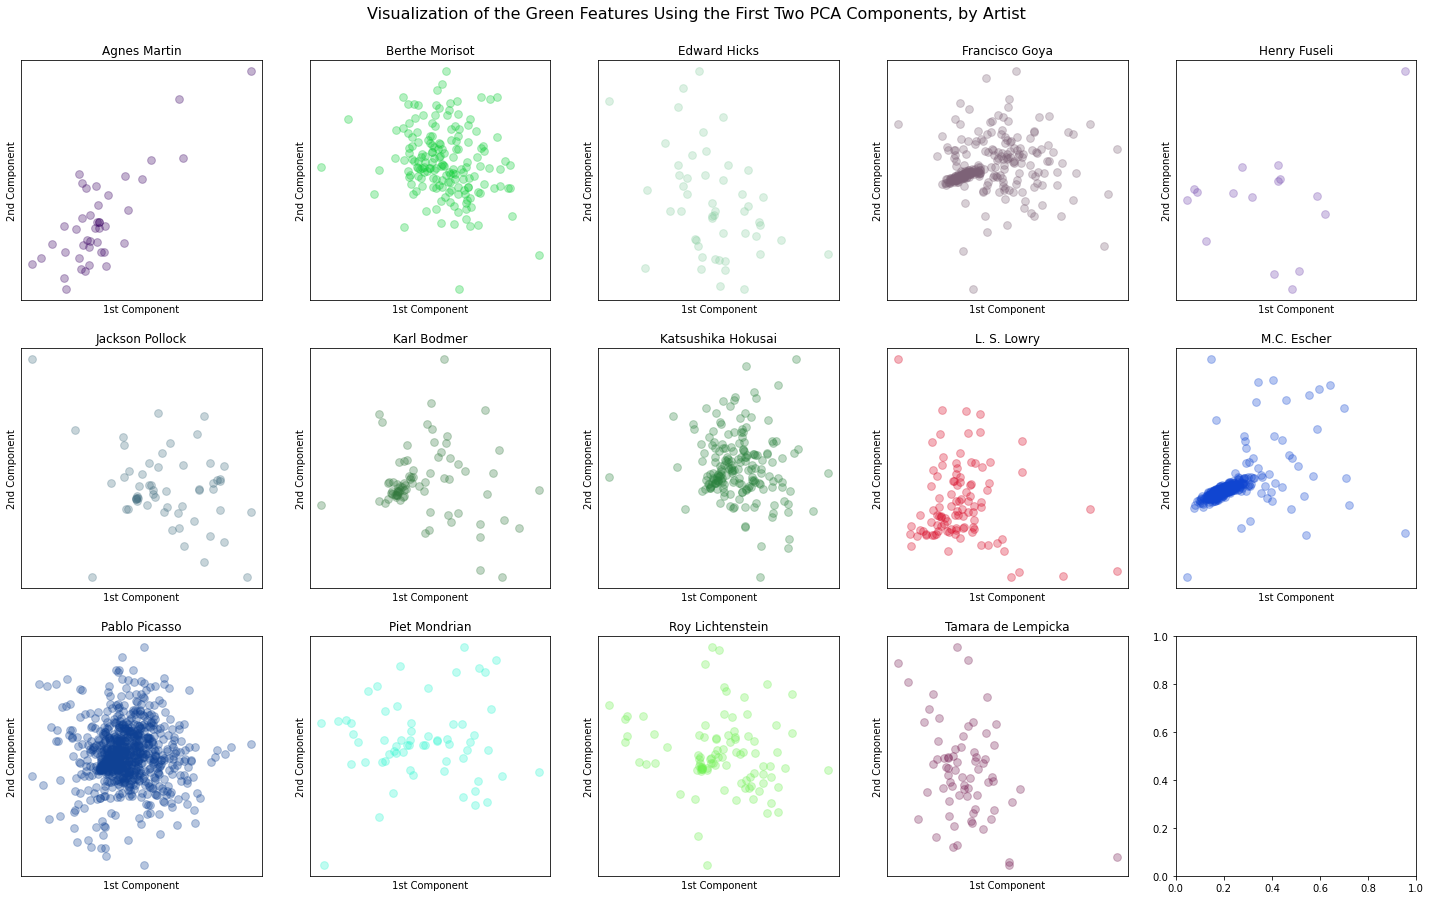

In [22]:
grid_target_components(pca_artist_g_dataset, artists, "Visualization of the Green Features Using the First Two PCA Components, by Artist")

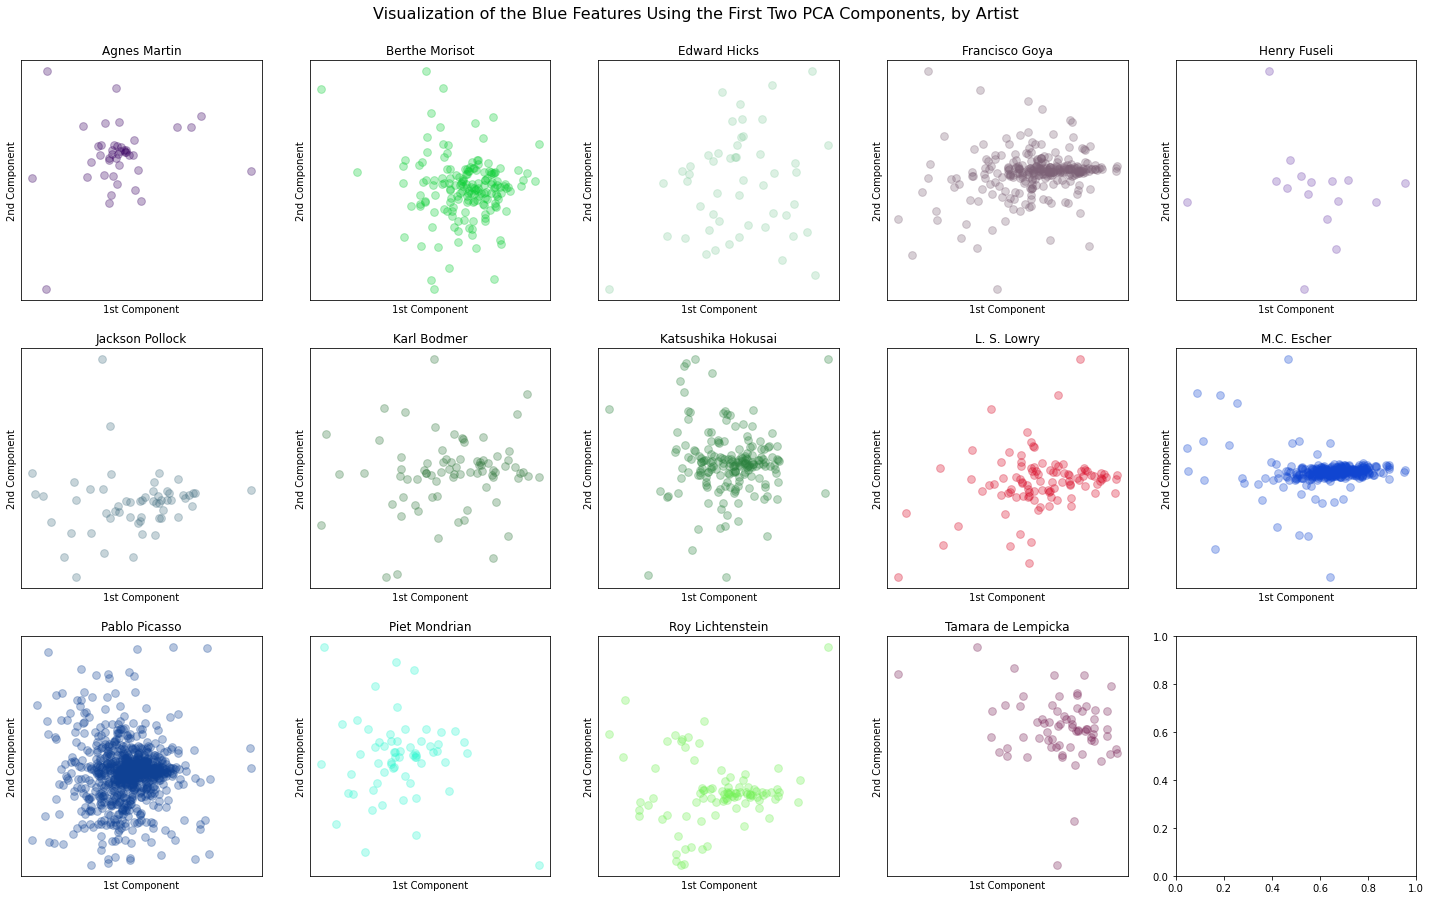

In [23]:
grid_target_components(pca_artist_b_dataset, artists, "Visualization of the Blue Features Using the First Two PCA Components, by Artist")

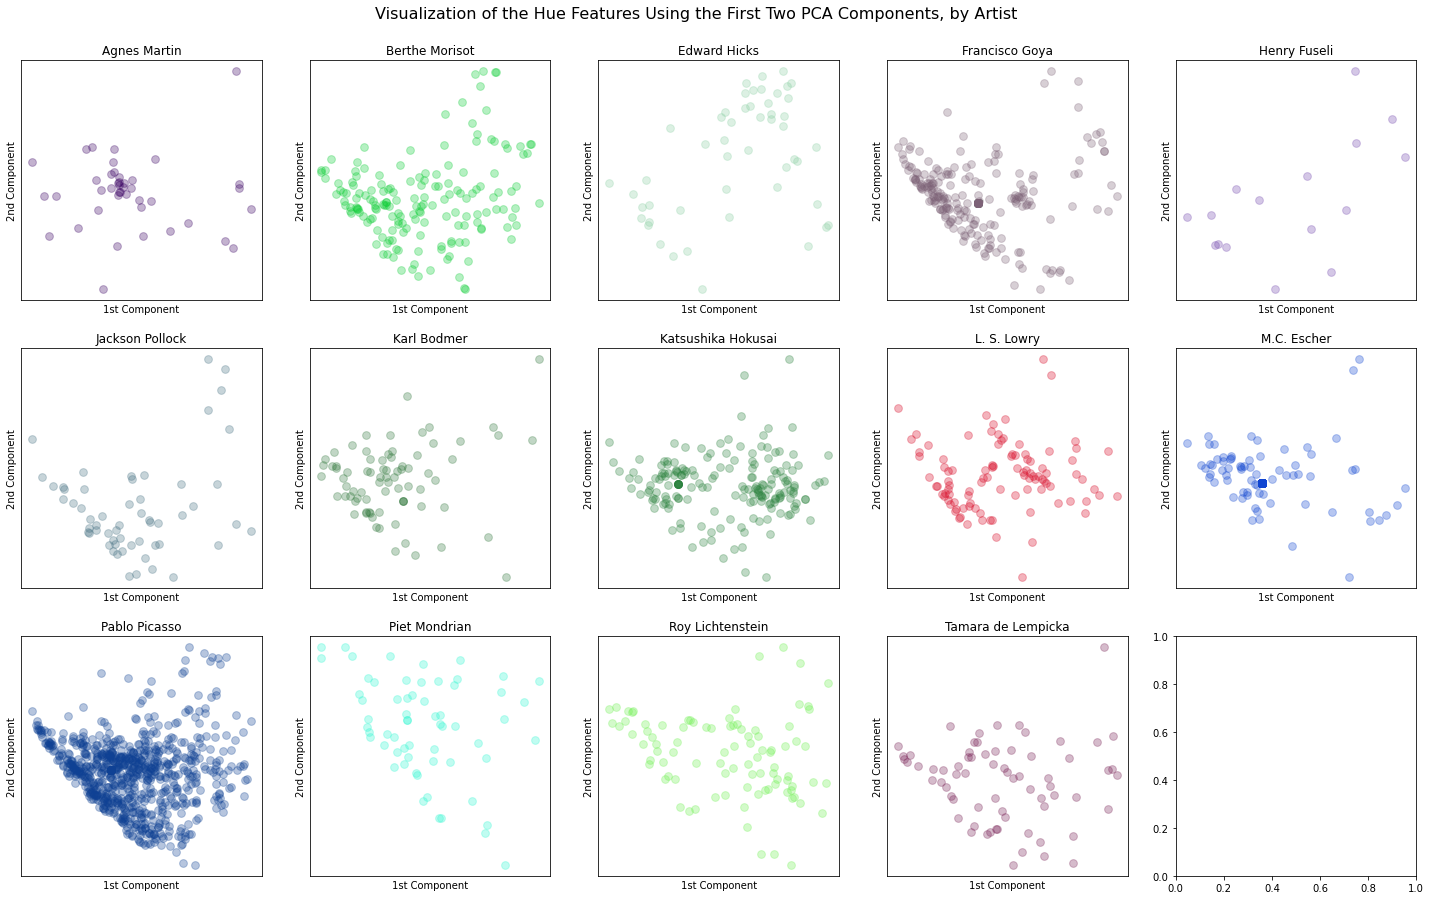

In [24]:
grid_target_components(pca_artist_h_dataset, artists, "Visualization of the Hue Features Using the First Two PCA Components, by Artist")

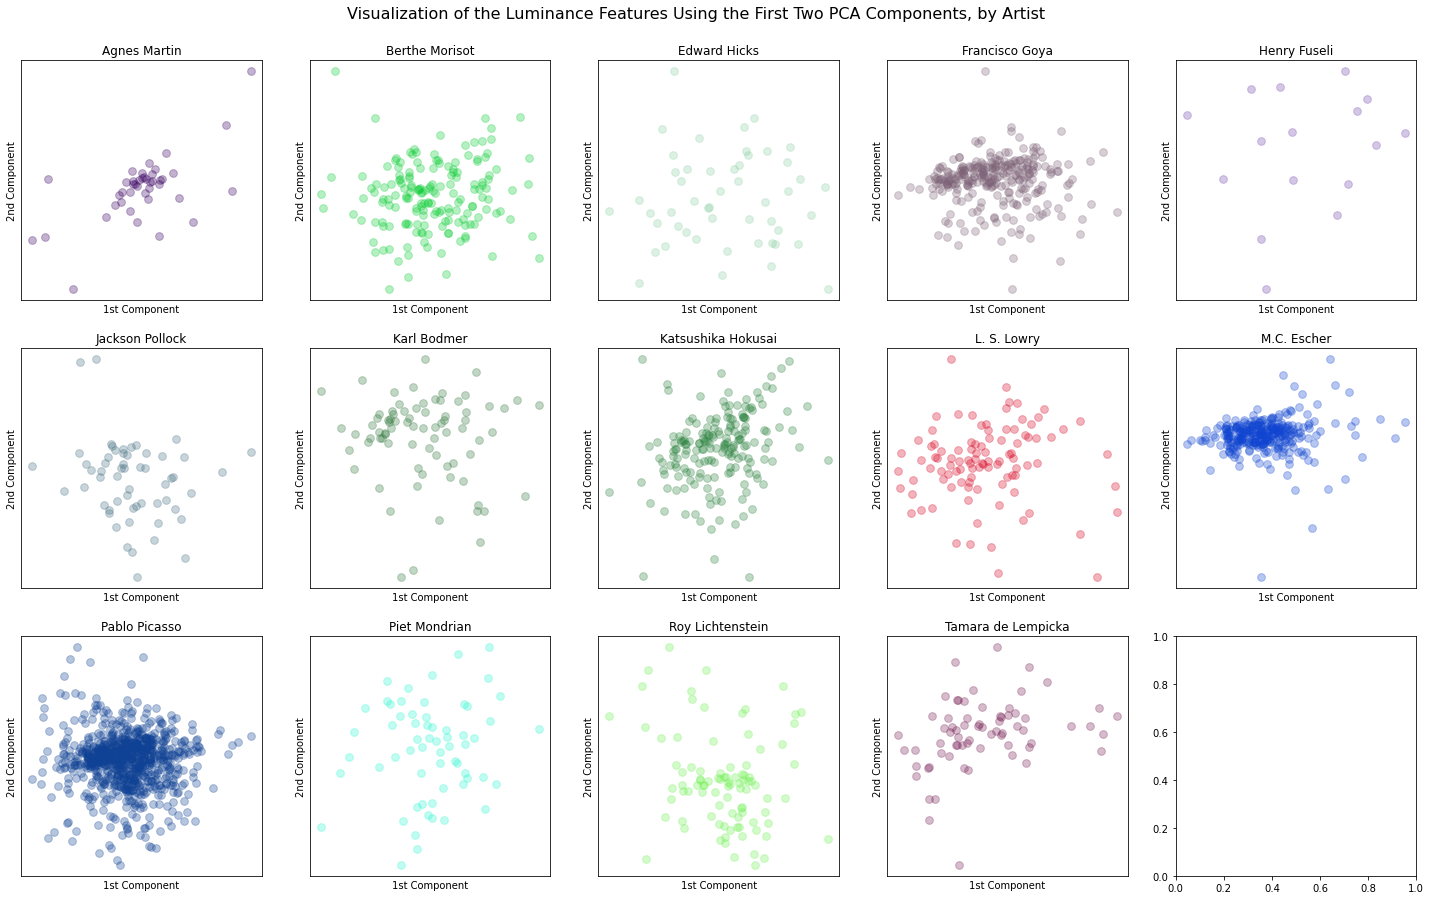

In [25]:
grid_target_components(pca_artist_l_dataset, artists, "Visualization of the Luminance Features Using the First Two PCA Components, by Artist")

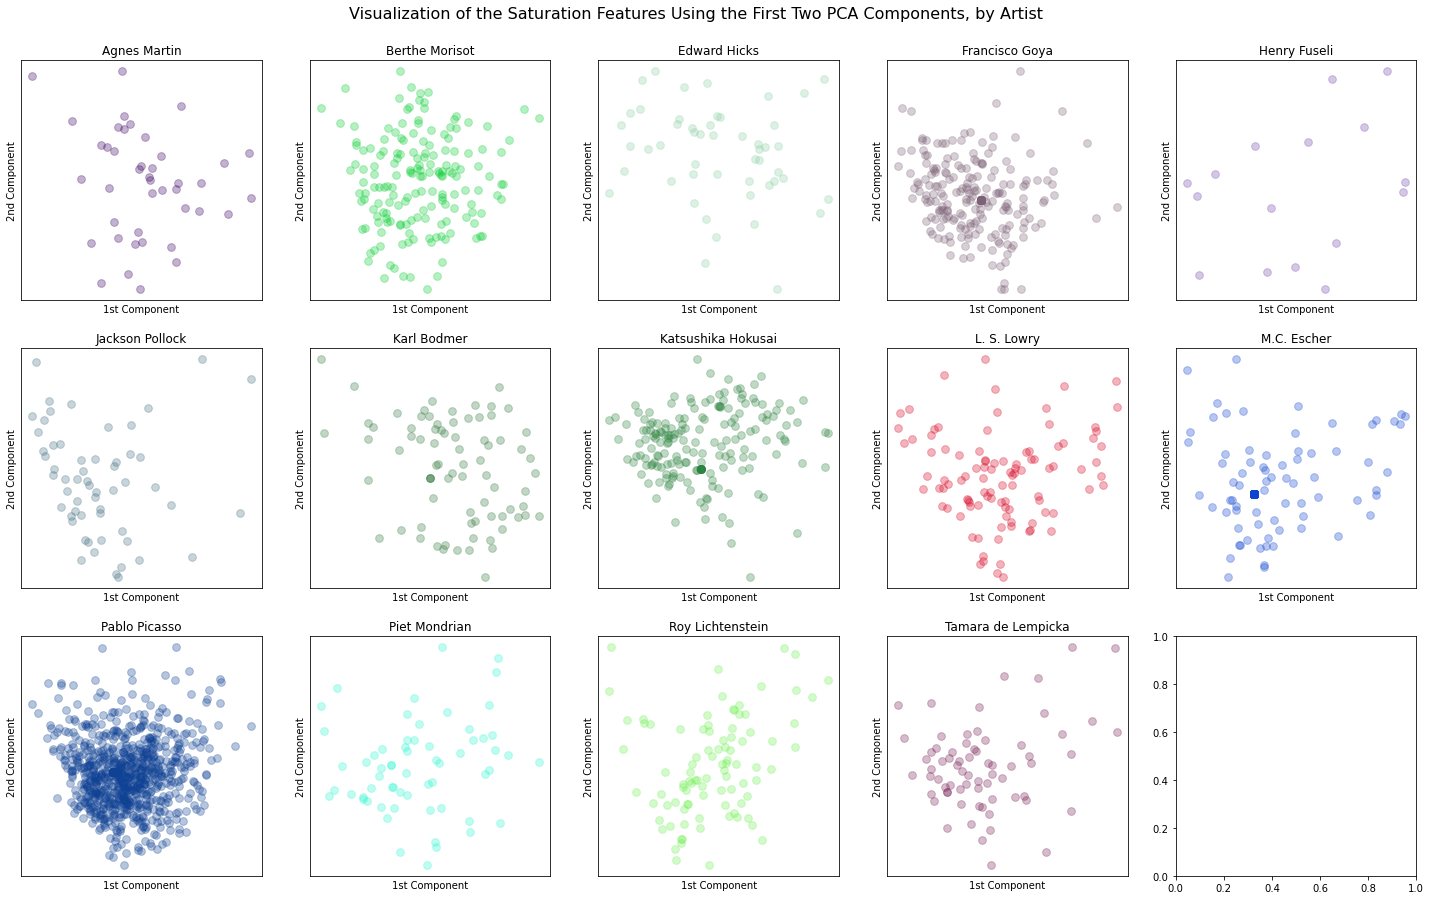

In [26]:
grid_target_components(pca_artist_s_dataset, artists, "Visualization of the Saturation Features Using the First Two PCA Components, by Artist")

## Display a Scree Plot for the Colours Data using the __R, G, B__ Colour System for Genre

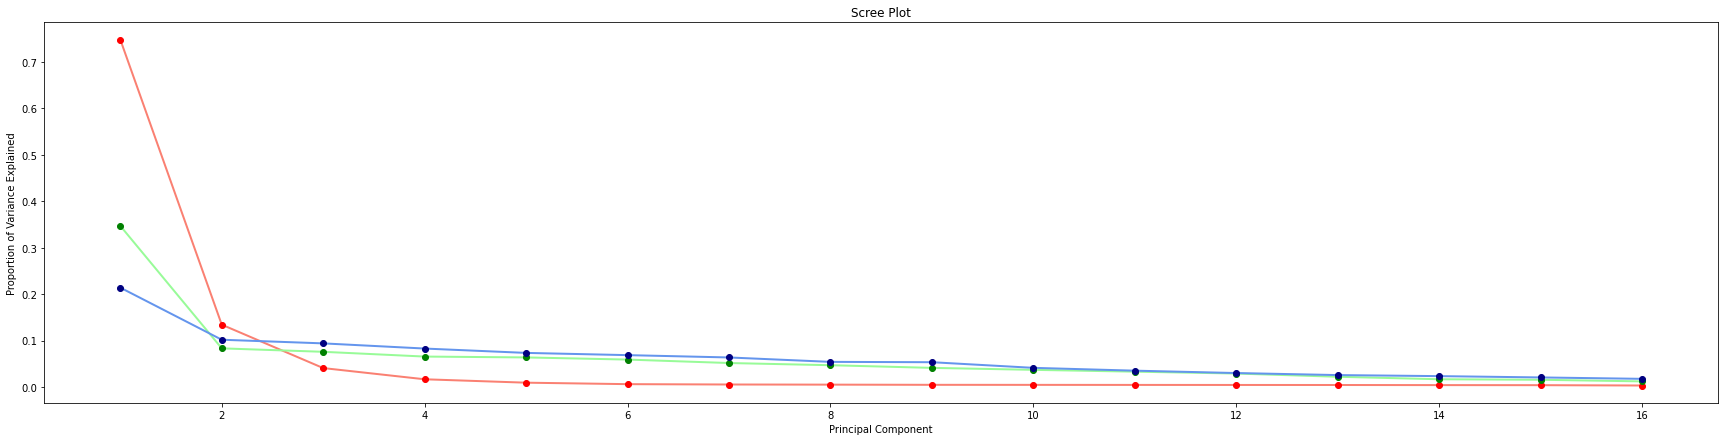

In [27]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, GENRE, DATA), read_data(COLOURS, TRAIN, GENRE, CATAGORY_NUM))

## Display a Scree Plot for the Colours Data using the __H, L, S__ Colour System Genre

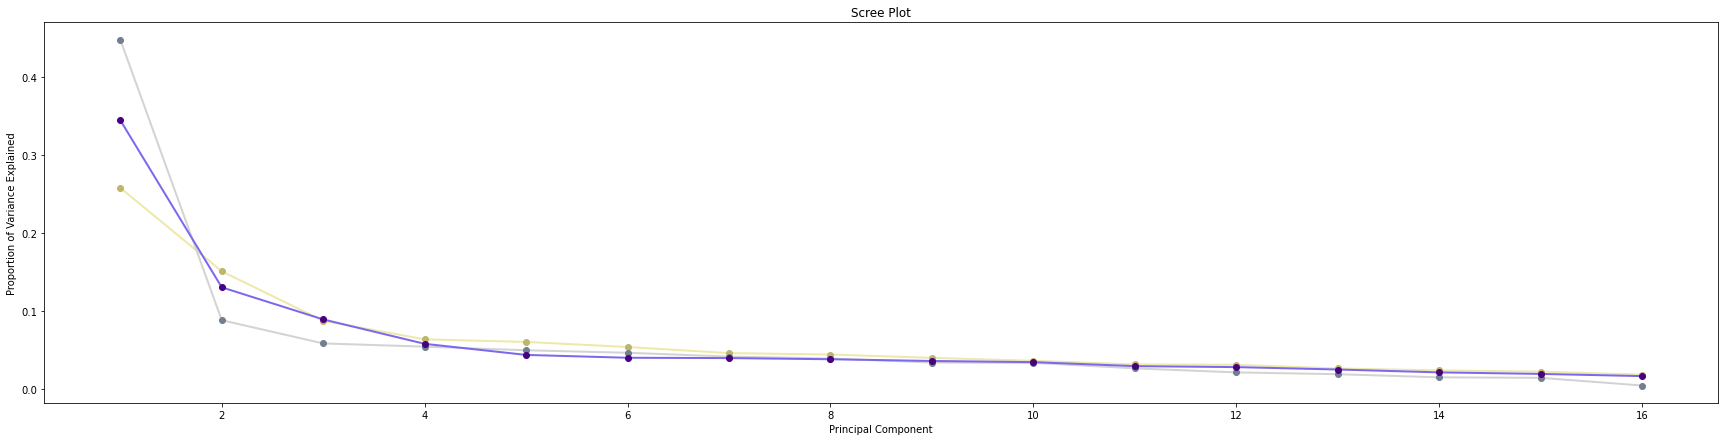

In [28]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, GENRE, DATA, HLS), read_data(COLOURS, TRAIN, GENRE, CATAGORY_NUM), HLS)

## Plot the First 2 __R, G, B__  Components of each Genre

In [29]:
# get the colou
genre_red_data, genre_blue_data, genre_green_data = read_data(PALETTES, TRAIN, GENRE, DATA)

In [30]:
# create colour pcs_datasets
pca_genre_r_dataset = create_pca_2_component_dataset(genre_red_data,   read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))
pca_genre_g_dataset = create_pca_2_component_dataset(genre_green_data, read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))
pca_genre_b_dataset = create_pca_2_component_dataset(genre_blue_data,  read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))

# populate layer column
pca_genre_r_dataset["layer"] = "Red"
pca_genre_g_dataset["layer"] = "Green"
pca_genre_b_dataset["layer"] = "Blue"

# construct the plot dataset
plot_data = pca_genre_r_dataset
plot_data = plot_data.append(pca_genre_g_dataset)
plot_data = plot_data.append(pca_genre_b_dataset)

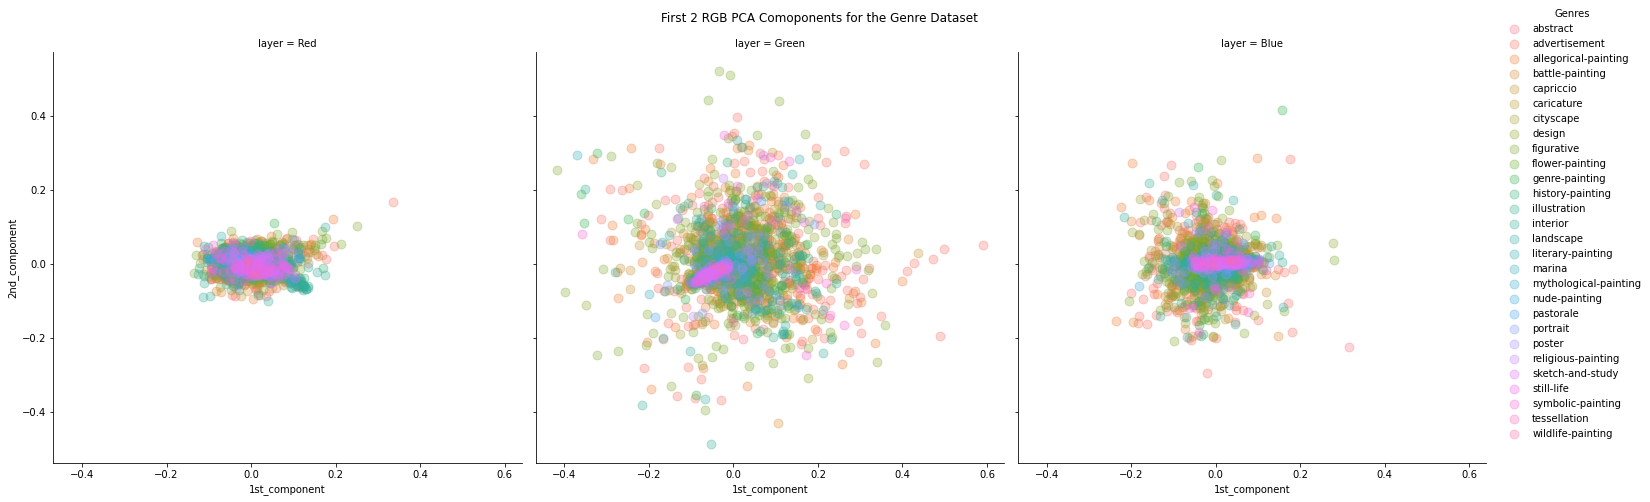

In [31]:
# combined artists pcs plots for r, g & b
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = genres, title = "Genres")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 RGB PCA Comoponents for the Genre Dataset')

# view the plots
plt.show()

## Plot the First 2 __H, L, S__  Components of each Genre

In [32]:
# get the colour data
genre_hue_data, genre_luminance_data, genre_saturation_data = read_data(PALETTES, TRAIN, GENRE, DATA, HLS)

In [33]:
# create colour pcs_datasets
pca_genre_h_dataset = create_pca_2_component_dataset(genre_hue_data,        read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))
pca_genre_l_dataset = create_pca_2_component_dataset(genre_luminance_data,  read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))
pca_genre_s_dataset = create_pca_2_component_dataset(genre_saturation_data, read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))

# populate layer column
pca_genre_h_dataset["layer"] = "Hue"
pca_genre_l_dataset["layer"] = "Luminance"
pca_genre_s_dataset["layer"] = "Saturation"

# construct the plot dataset
plot_data = pca_genre_h_dataset
plot_data = plot_data.append(pca_genre_l_dataset)
plot_data = plot_data.append(pca_genre_s_dataset)

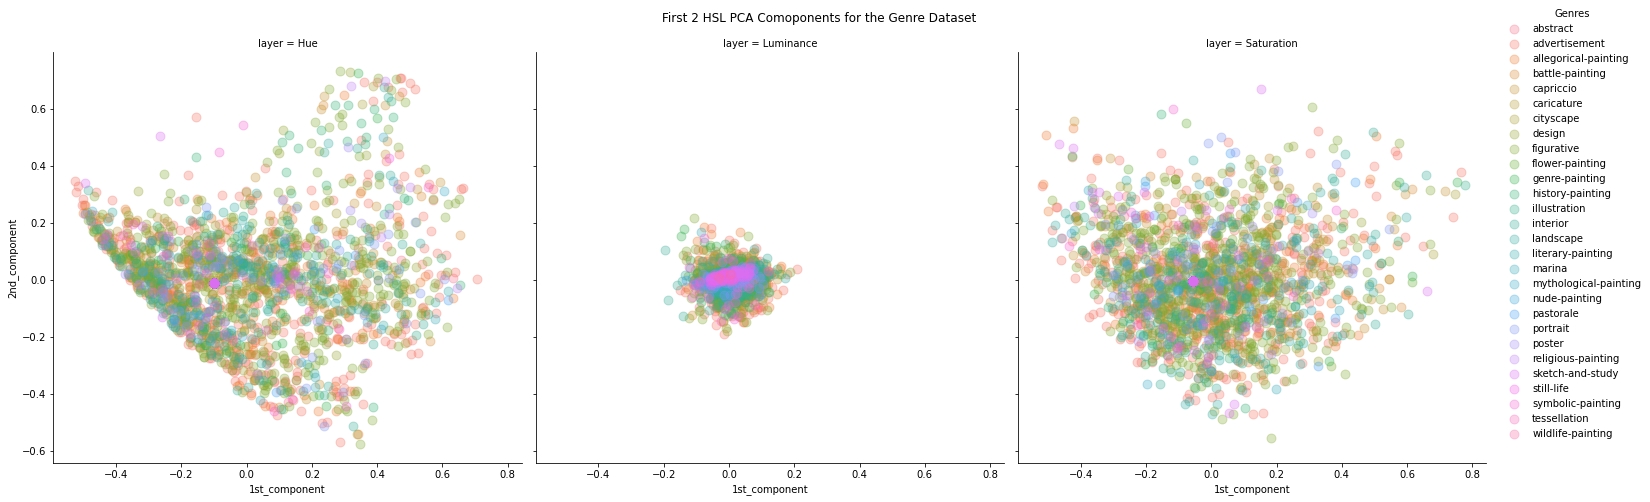

In [34]:
# combined artists pcs plots for h, l & s
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = genres, title = "Genres")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 HSL PCA Comoponents for the Genre Dataset')

# view the plots
plt.show()

That is a little hard to read. So, let´s try viewing the data by individual Genres. 

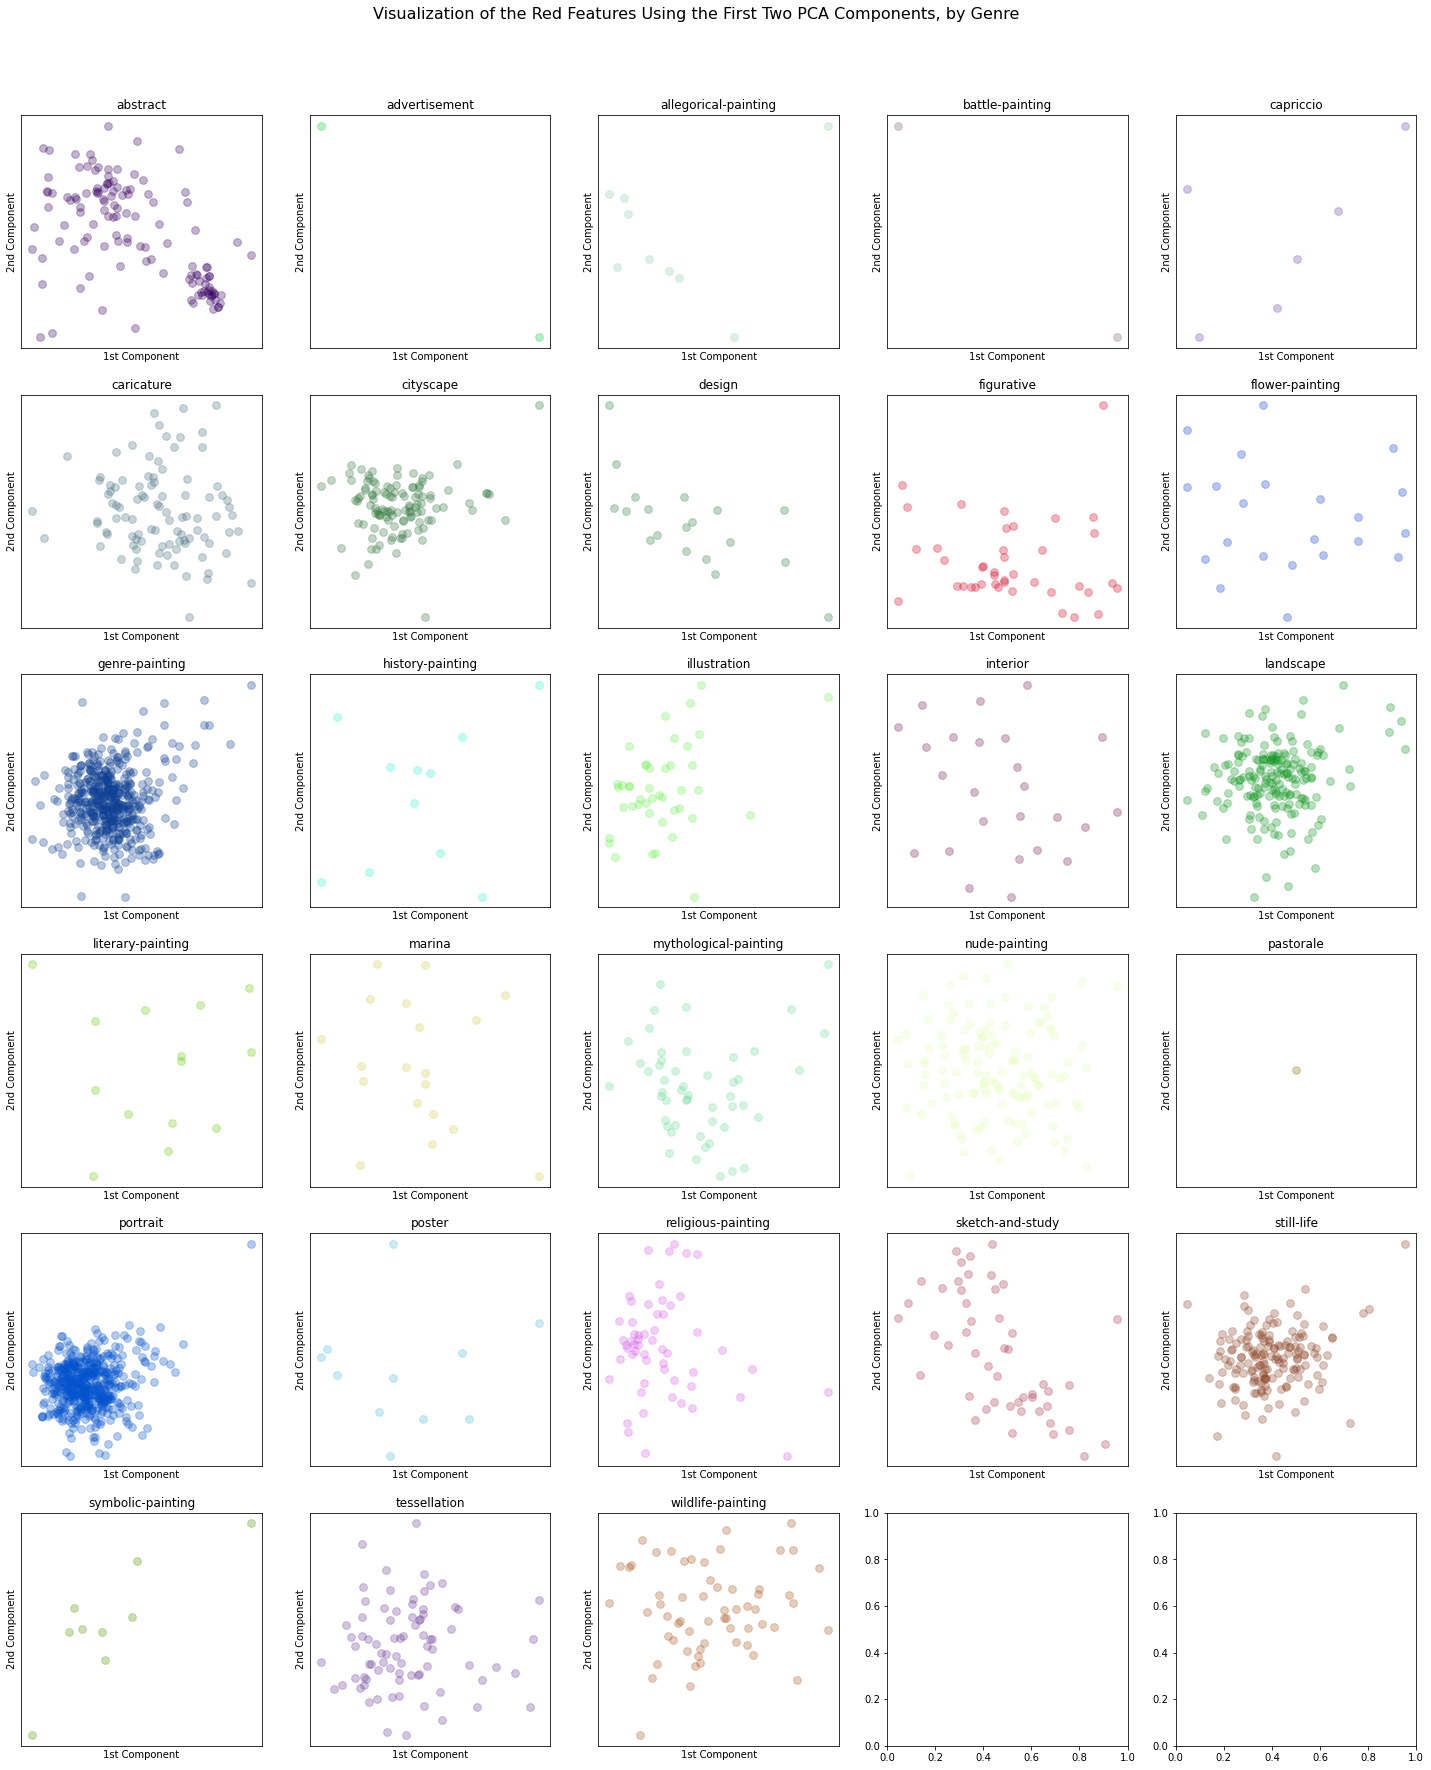

In [35]:
grid_target_components(pca_genre_r_dataset, genres, "Visualization of the Red Features Using the First Two PCA Components, by Genre")

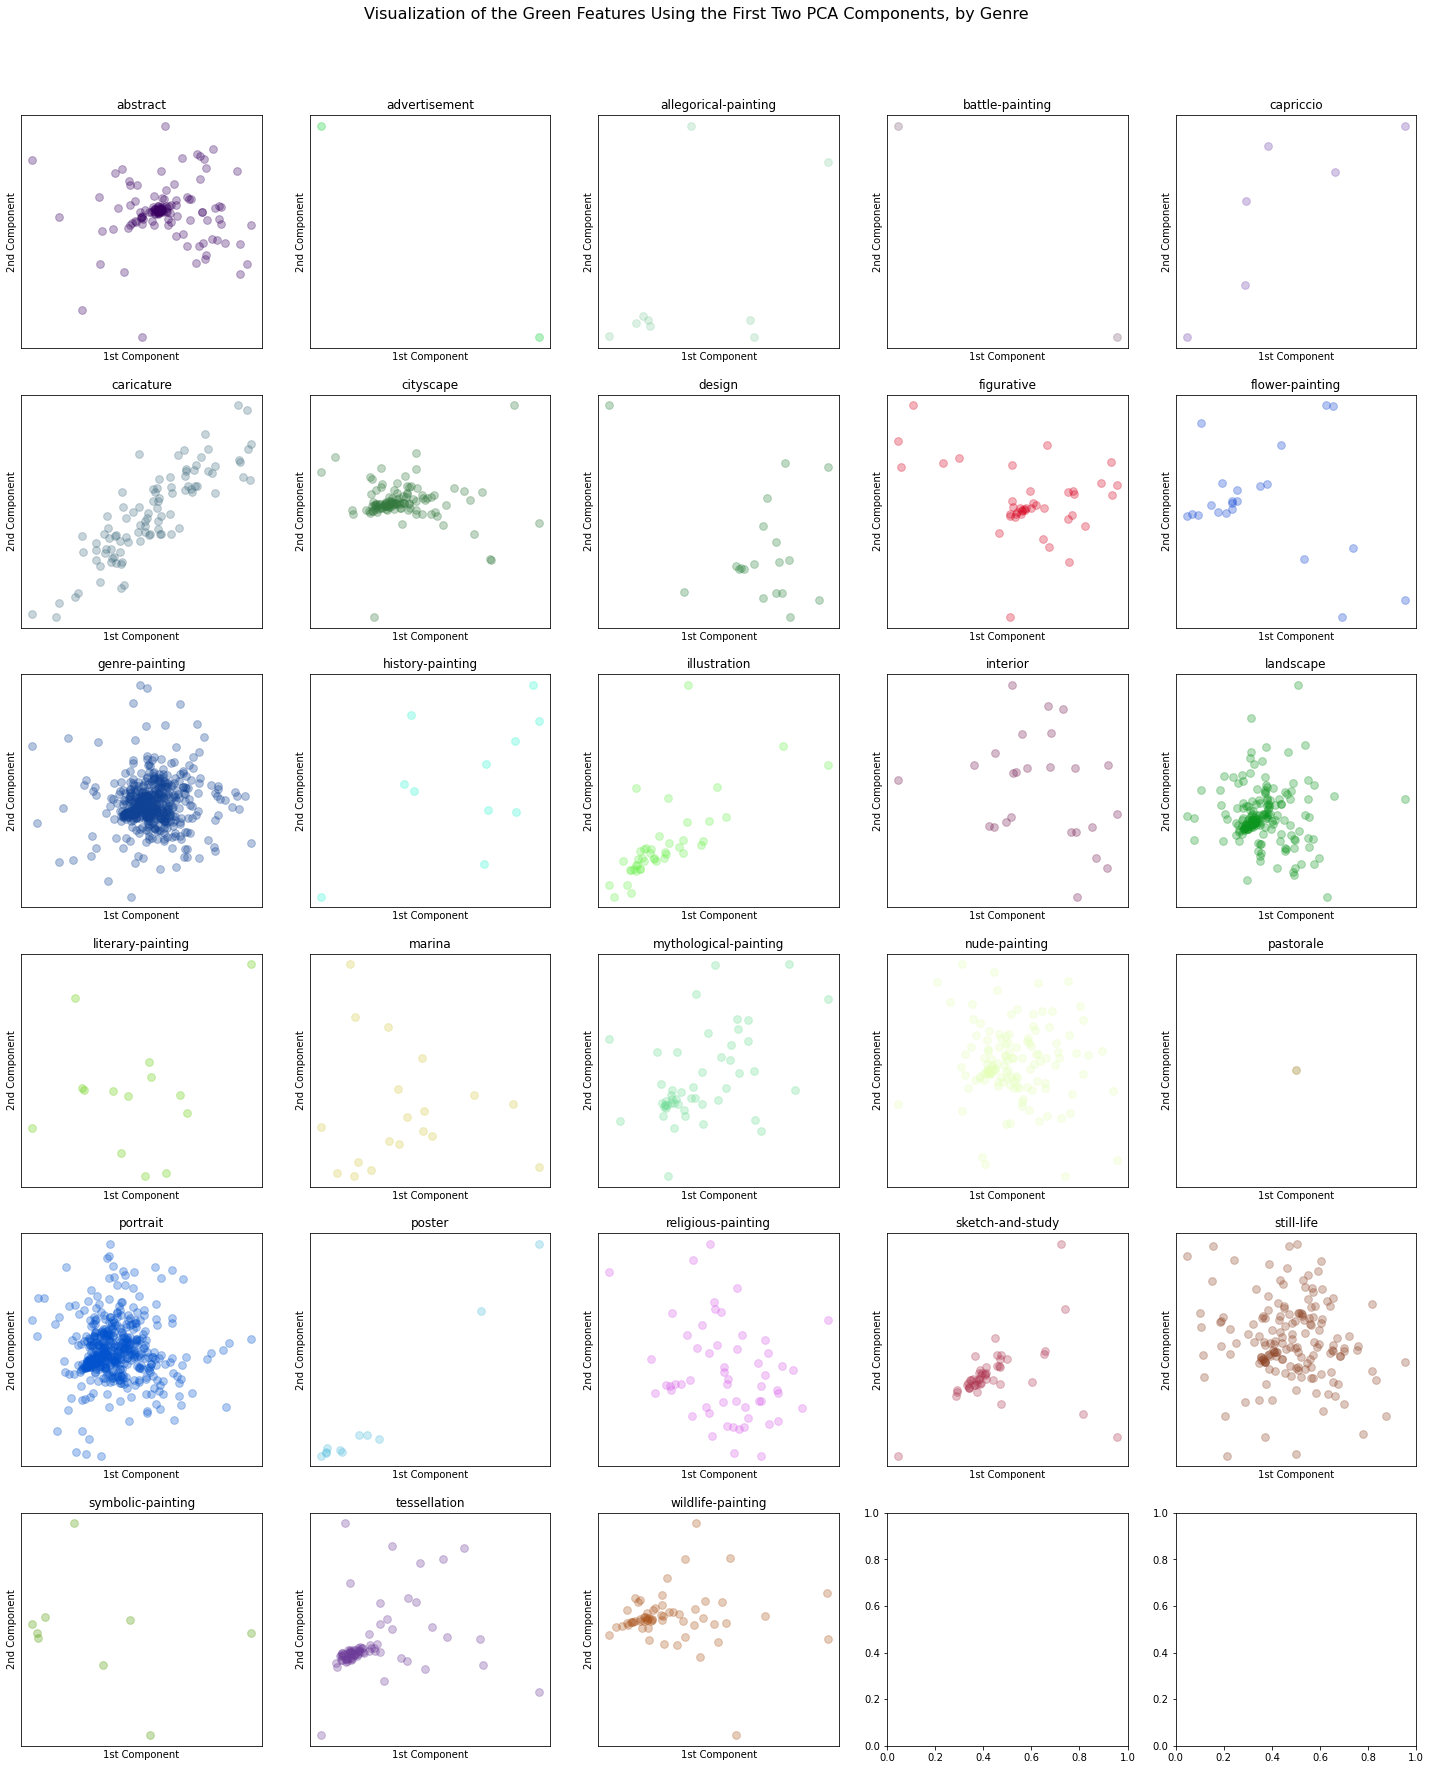

In [36]:
grid_target_components(pca_genre_g_dataset, genres, "Visualization of the Green Features Using the First Two PCA Components, by Genre")

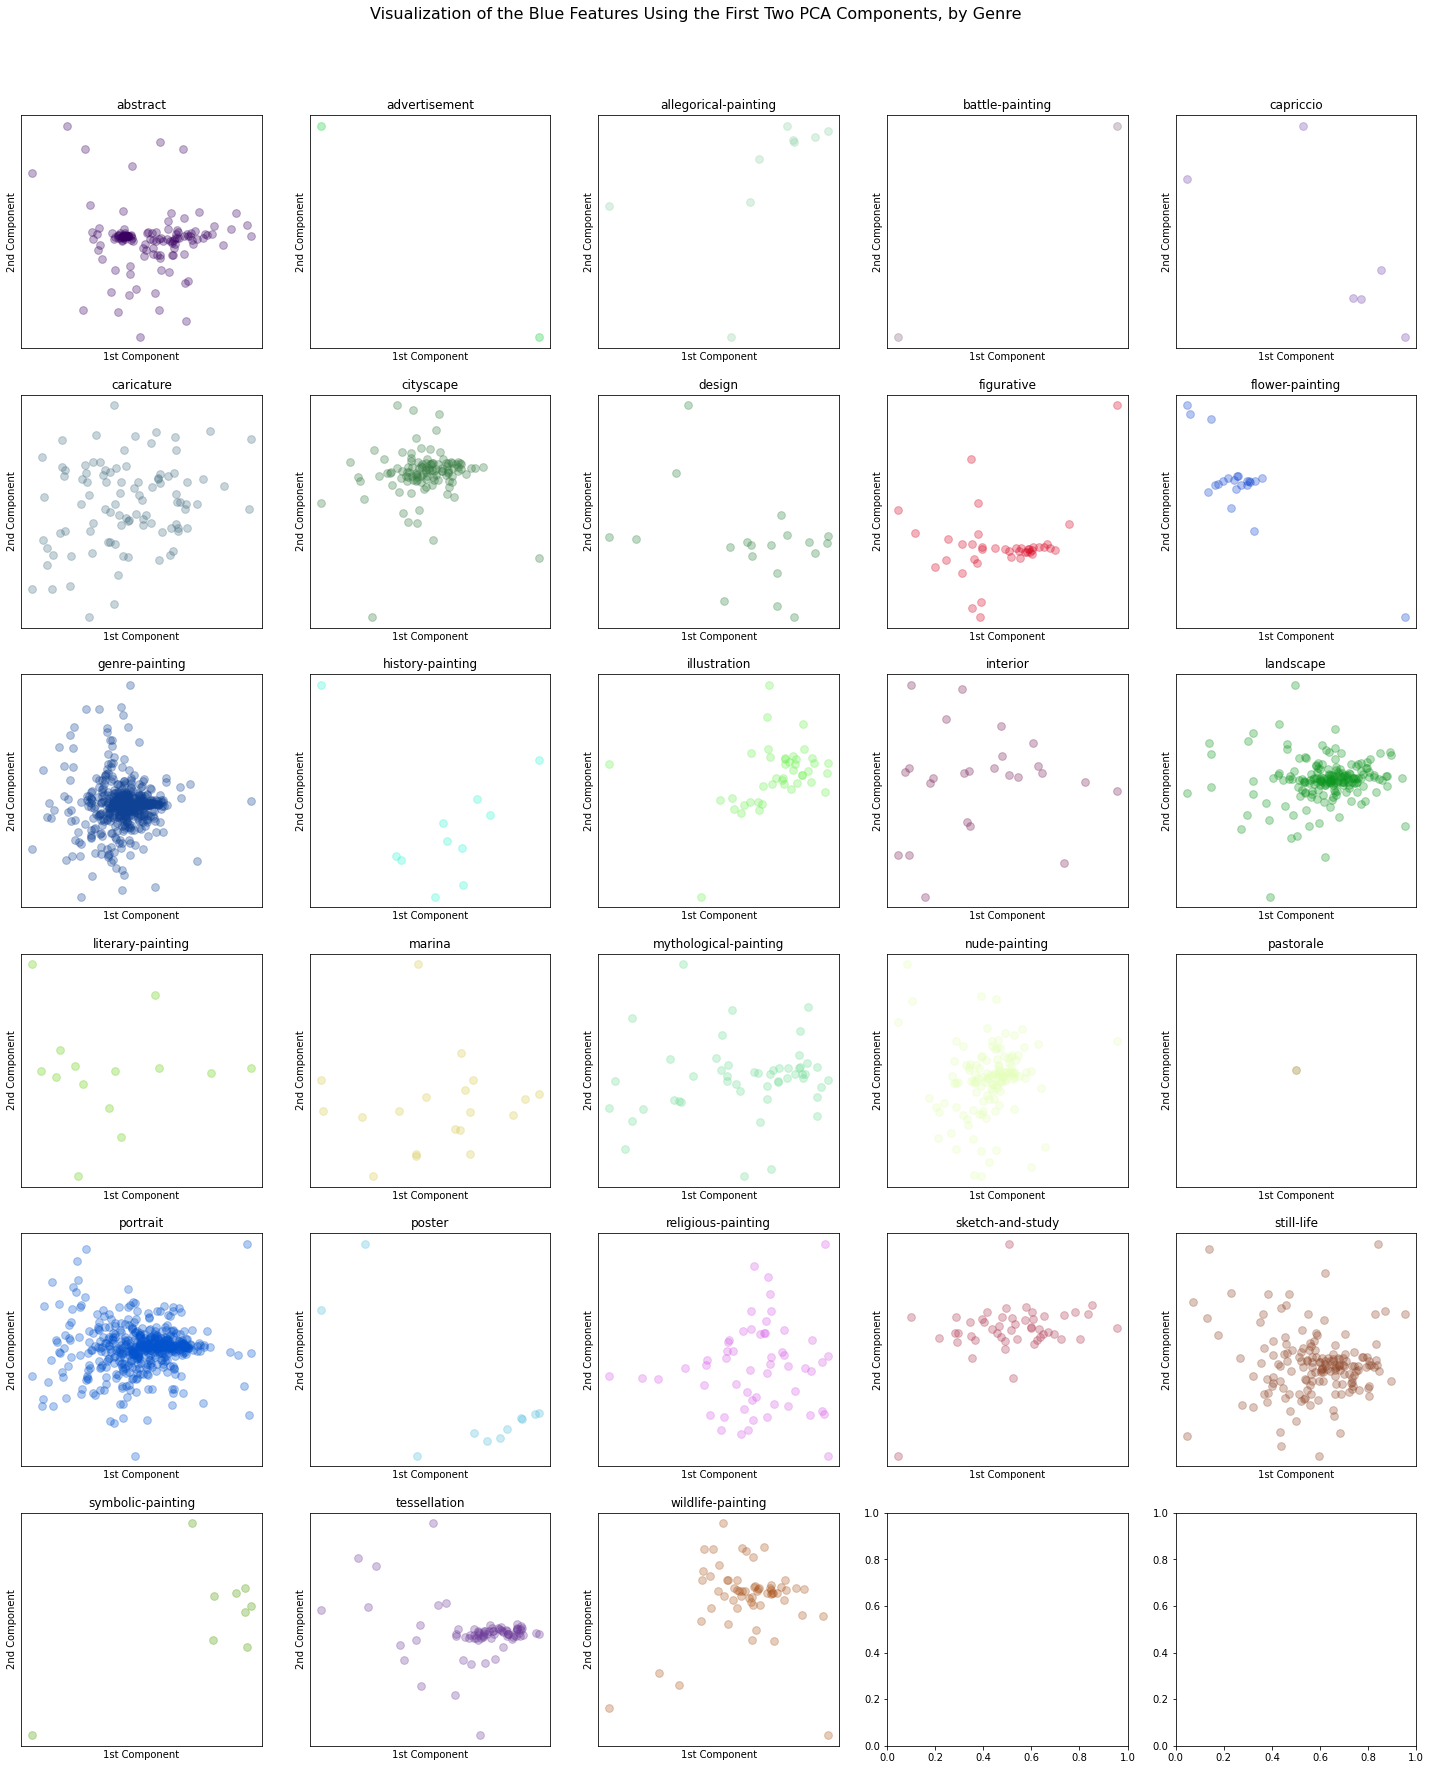

In [37]:
grid_target_components(pca_genre_b_dataset, genres, "Visualization of the Blue Features Using the First Two PCA Components, by Genre")

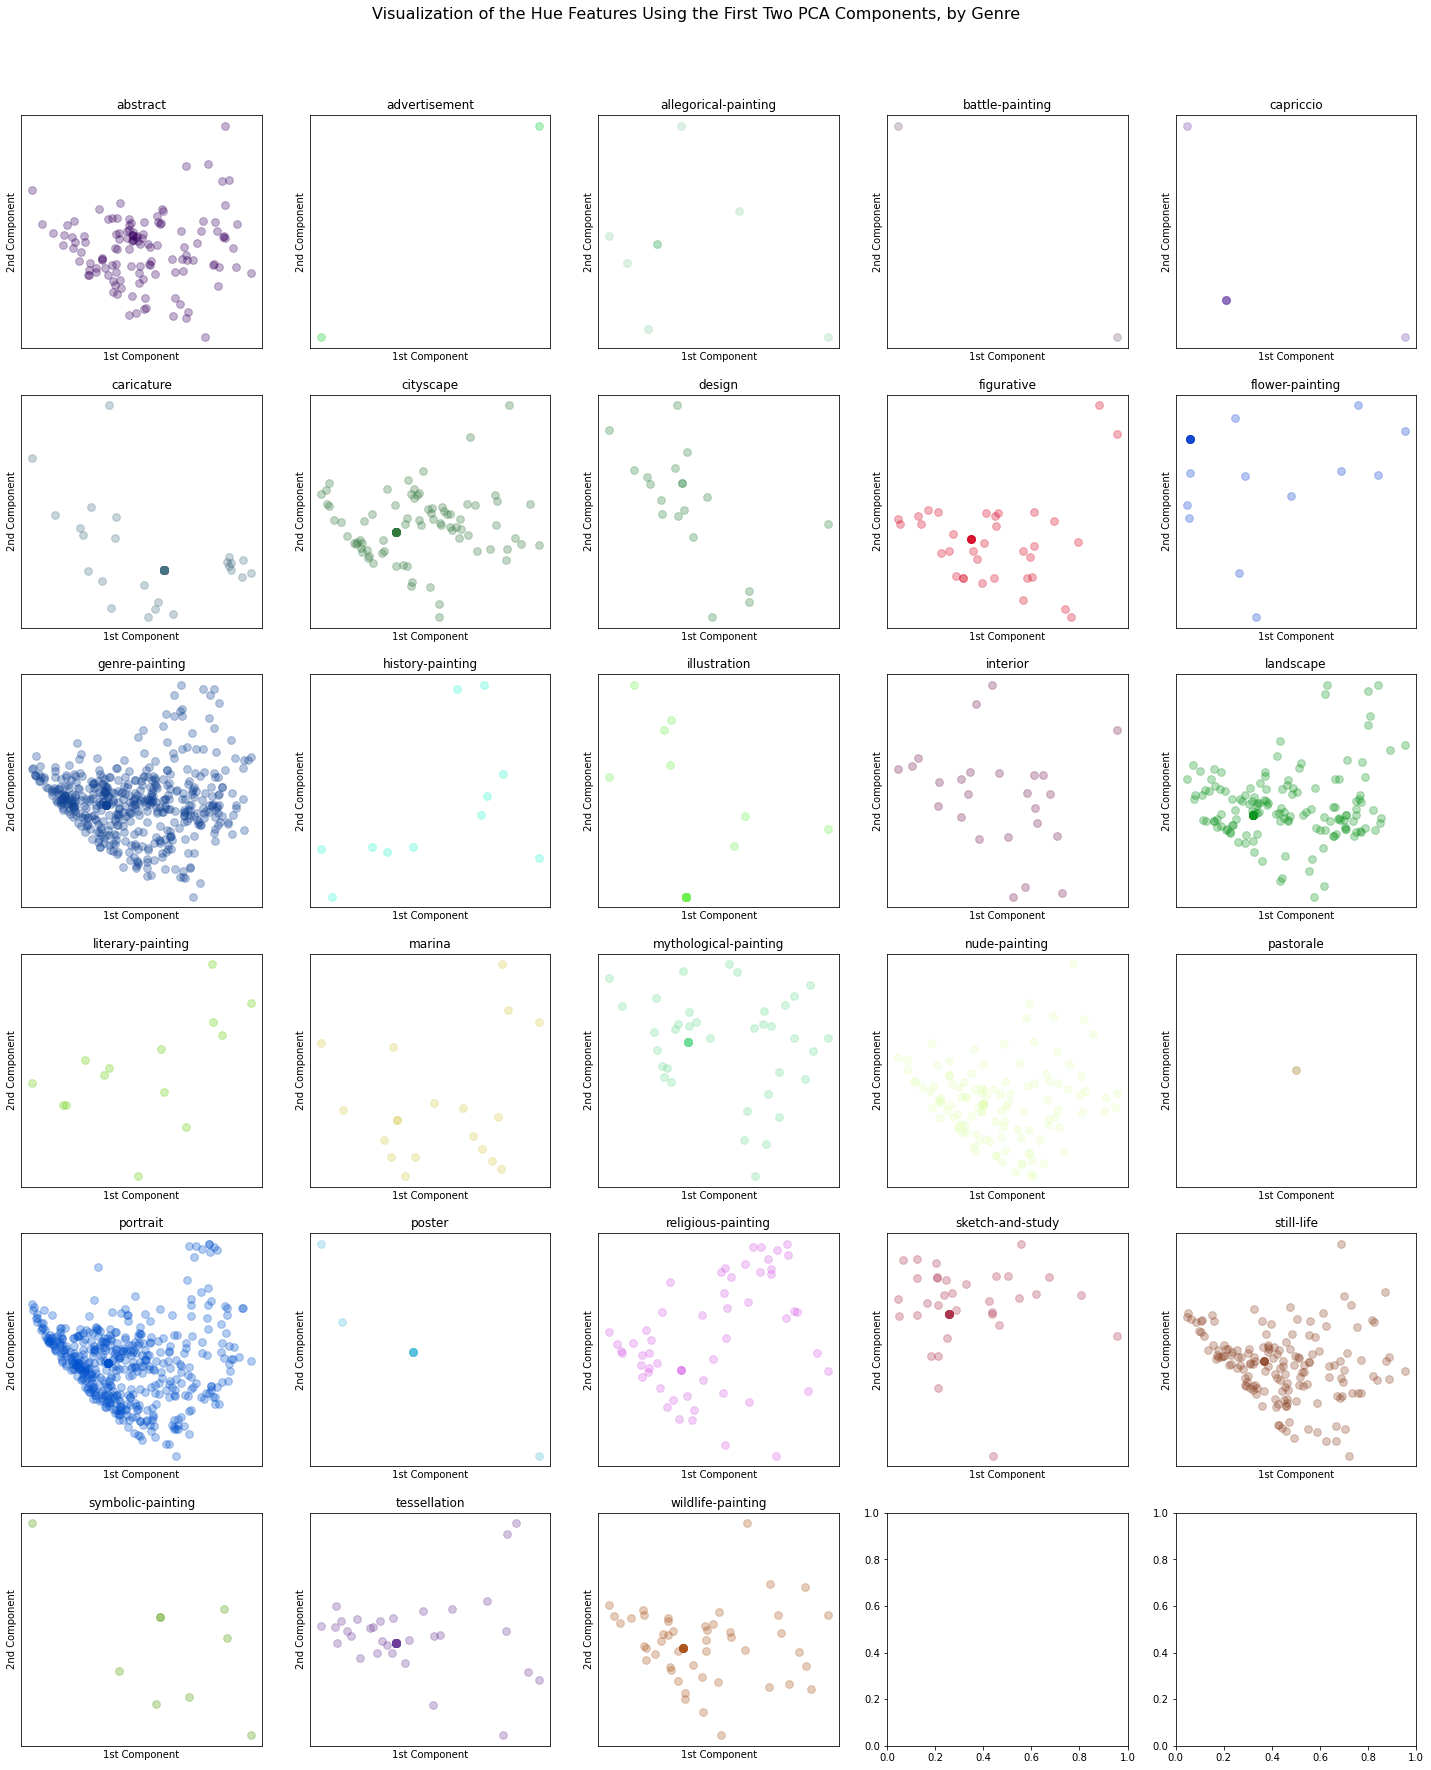

In [38]:
grid_target_components(pca_genre_h_dataset, genres, "Visualization of the Hue Features Using the First Two PCA Components, by Genre")

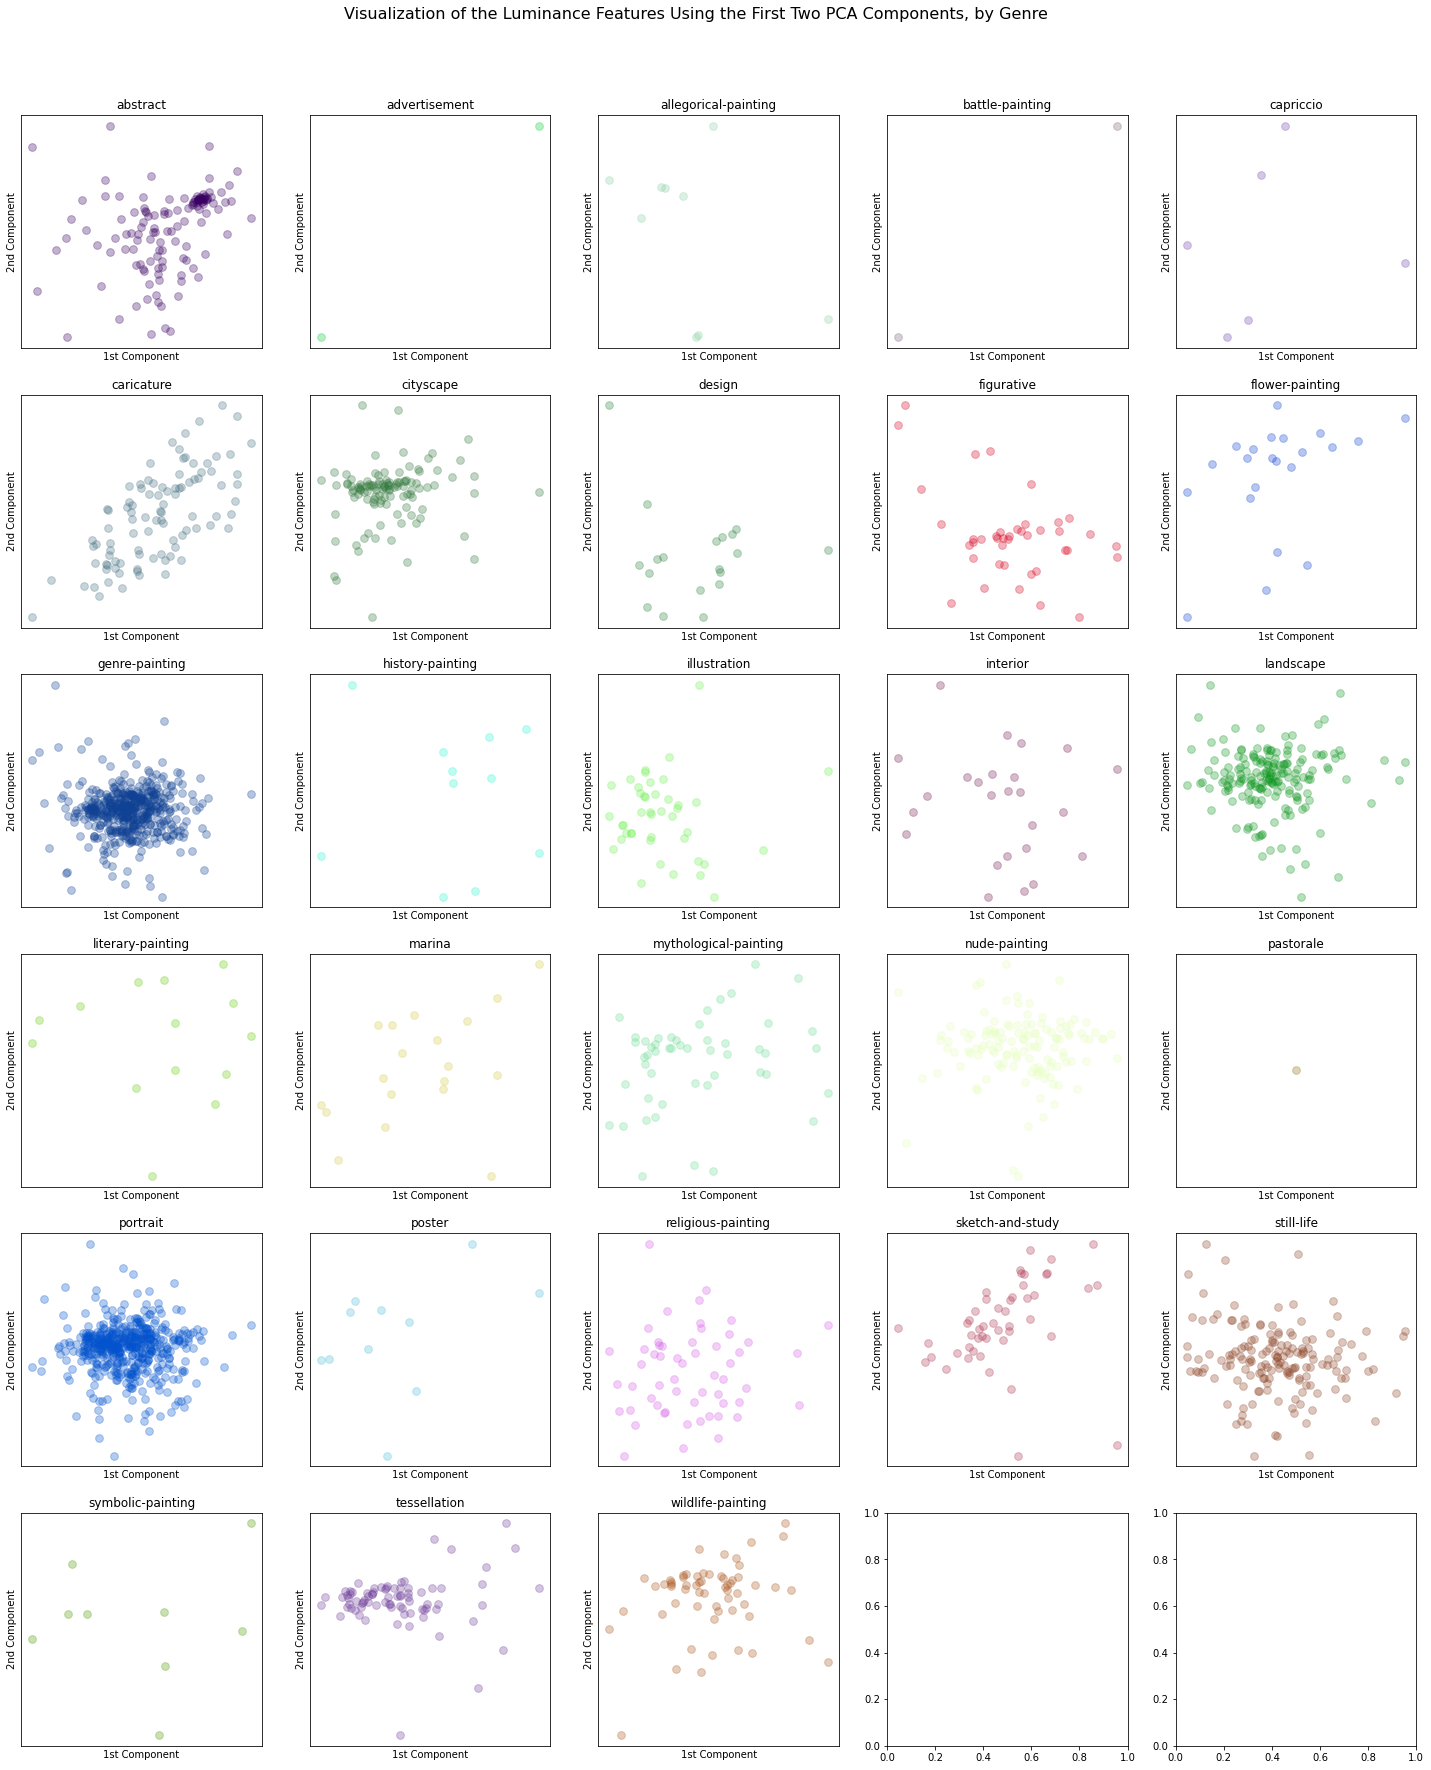

In [39]:
grid_target_components(pca_genre_l_dataset, genres, "Visualization of the Luminance Features Using the First Two PCA Components, by Genre")

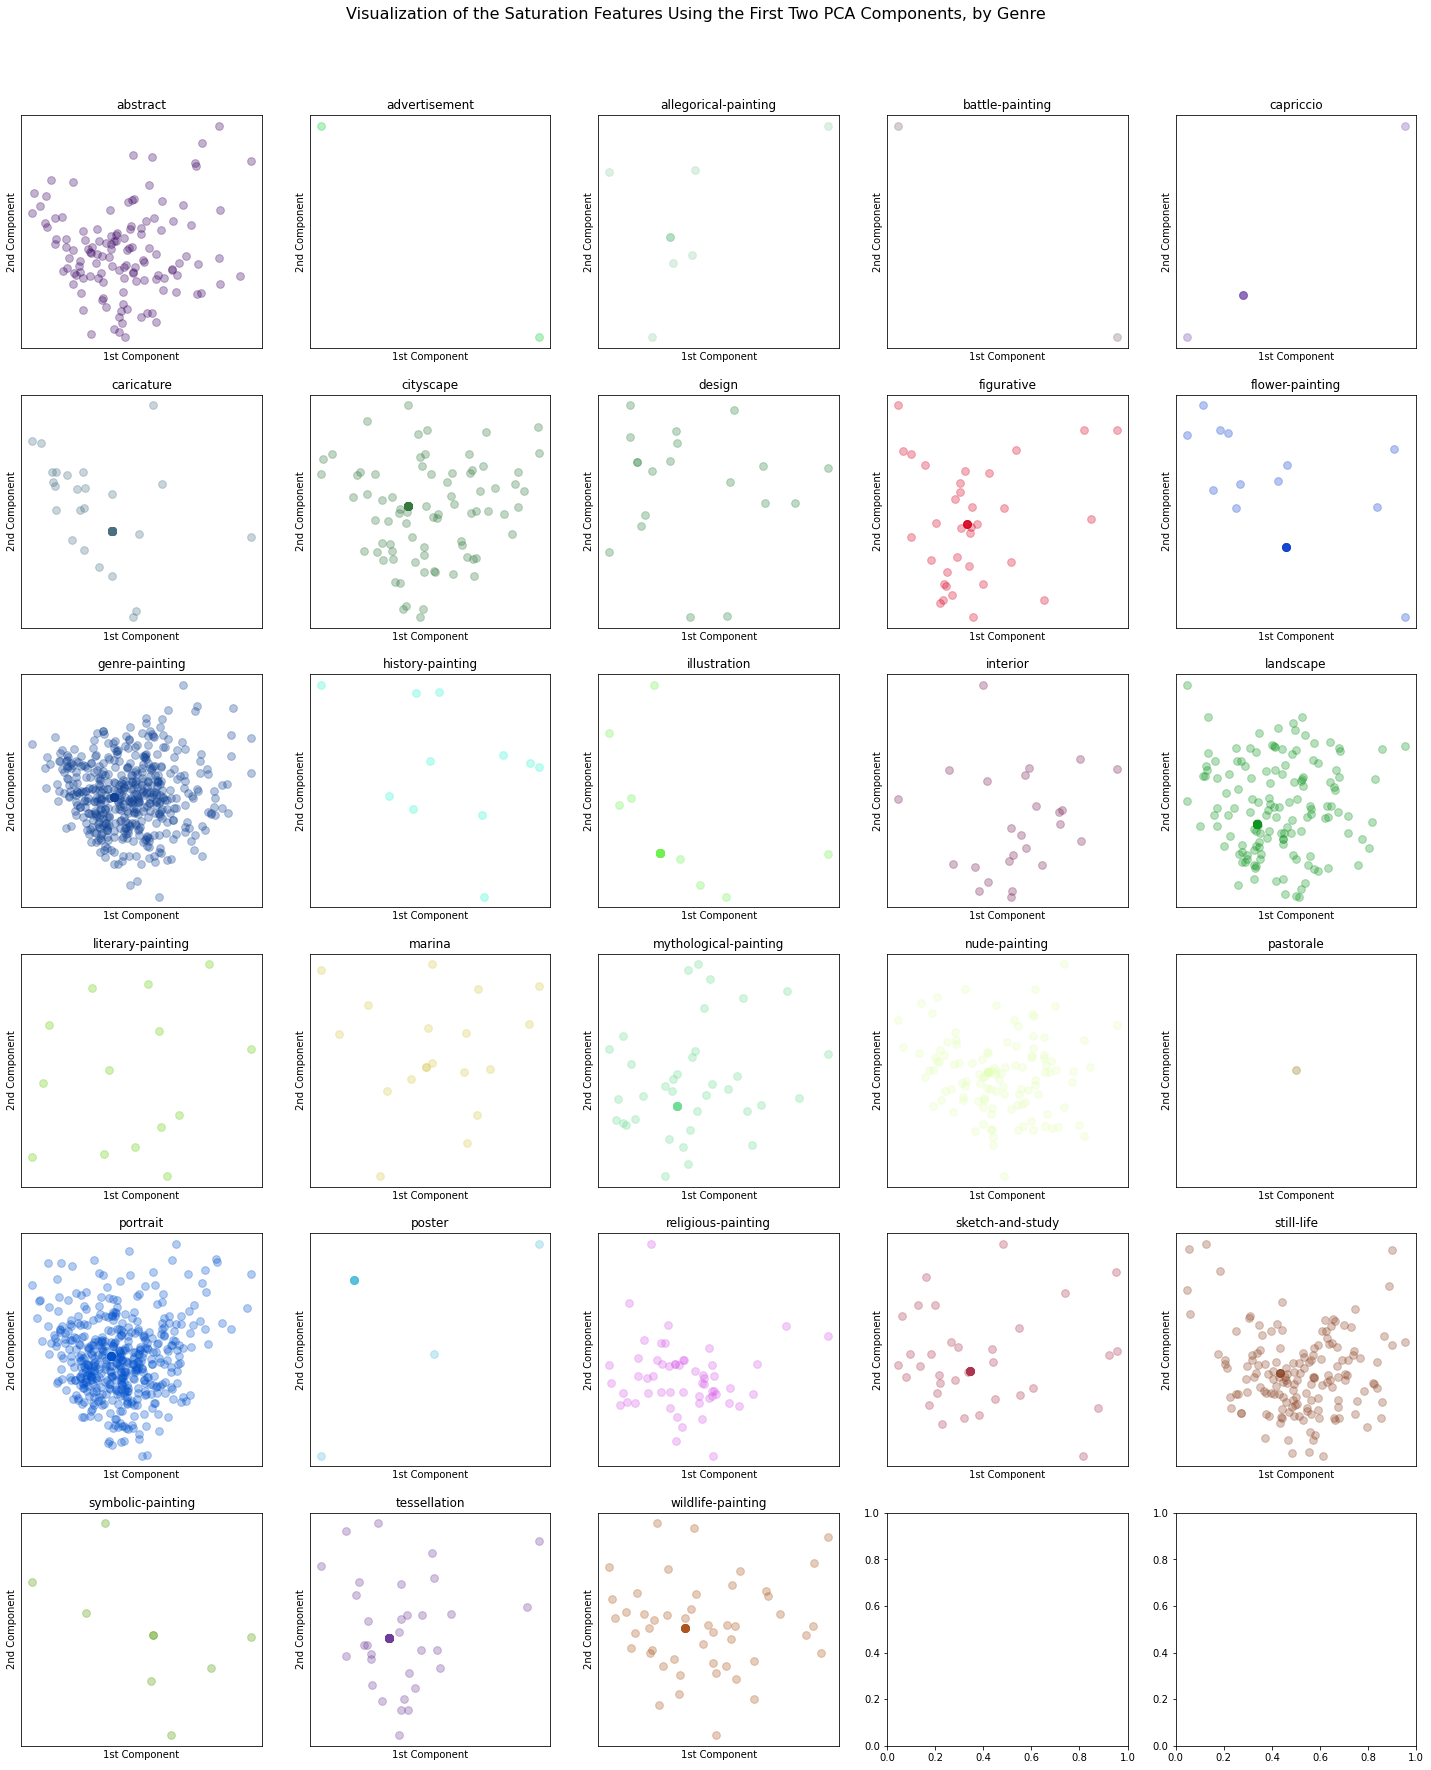

In [40]:
grid_target_components(pca_genre_s_dataset, genres, "Visualization of the Saturation Features Using the First Two PCA Components, by Genre")

## Display a Scree Plot for the Colours Data using the __R, G, B__ Colour System for Style

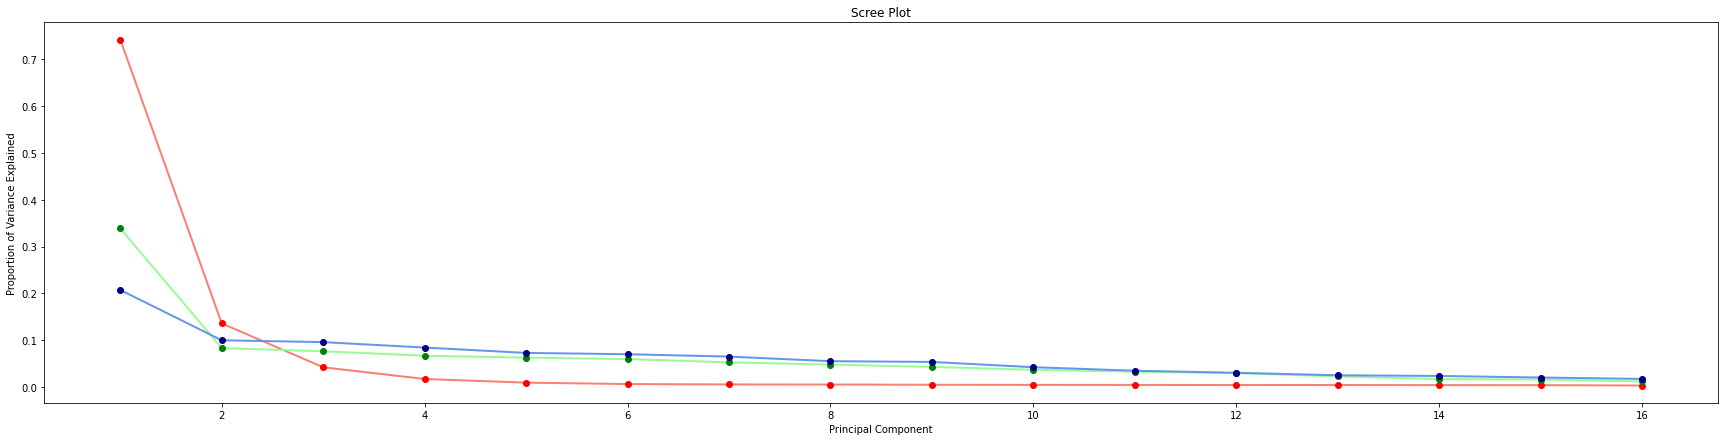

In [41]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, STYLE, DATA), read_data(COLOURS, TRAIN, STYLE, CATAGORY_NUM))

## Display a Scree Plot for the Colours Data using the __H, L, S__ Colour System Style

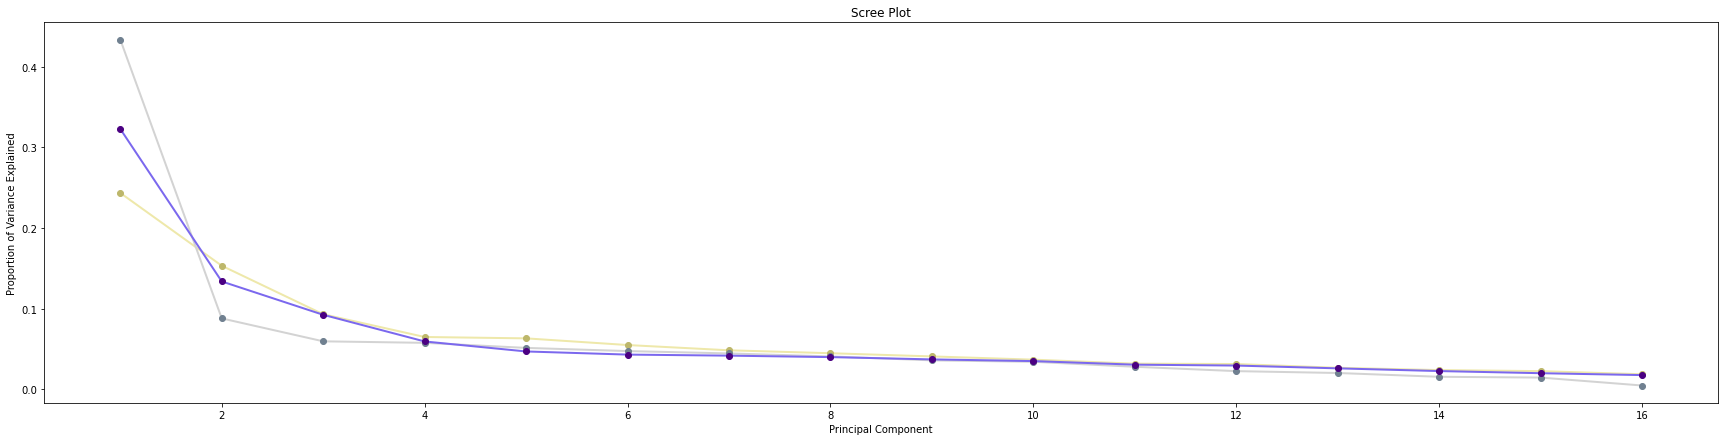

In [42]:
create_pca_scree_plot(read_data(PALETTES, TRAIN, STYLE, DATA, HLS), read_data(COLOURS, TRAIN, STYLE, CATAGORY_NUM), HLS)

## Plot the First 2 __R, G, B__  Components of each Style

In [43]:
# get the colour
style_red_data, style_blue_data, style_green_data = read_data(PALETTES, TRAIN, STYLE, DATA)

In [44]:
# create colour pcs_datasets
pca_style_r_dataset = create_pca_2_component_dataset(style_red_data,   read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))
pca_style_g_dataset = create_pca_2_component_dataset(style_green_data, read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))
pca_style_b_dataset = create_pca_2_component_dataset(style_blue_data,  read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))

# populate layer column
pca_style_r_dataset["layer"] = "Red"
pca_style_g_dataset["layer"] = "Green"
pca_style_b_dataset["layer"] = "Blue"

# construct the plot dataset
plot_data = pca_style_r_dataset
plot_data = plot_data.append(pca_style_g_dataset)
plot_data = plot_data.append(pca_style_b_dataset)

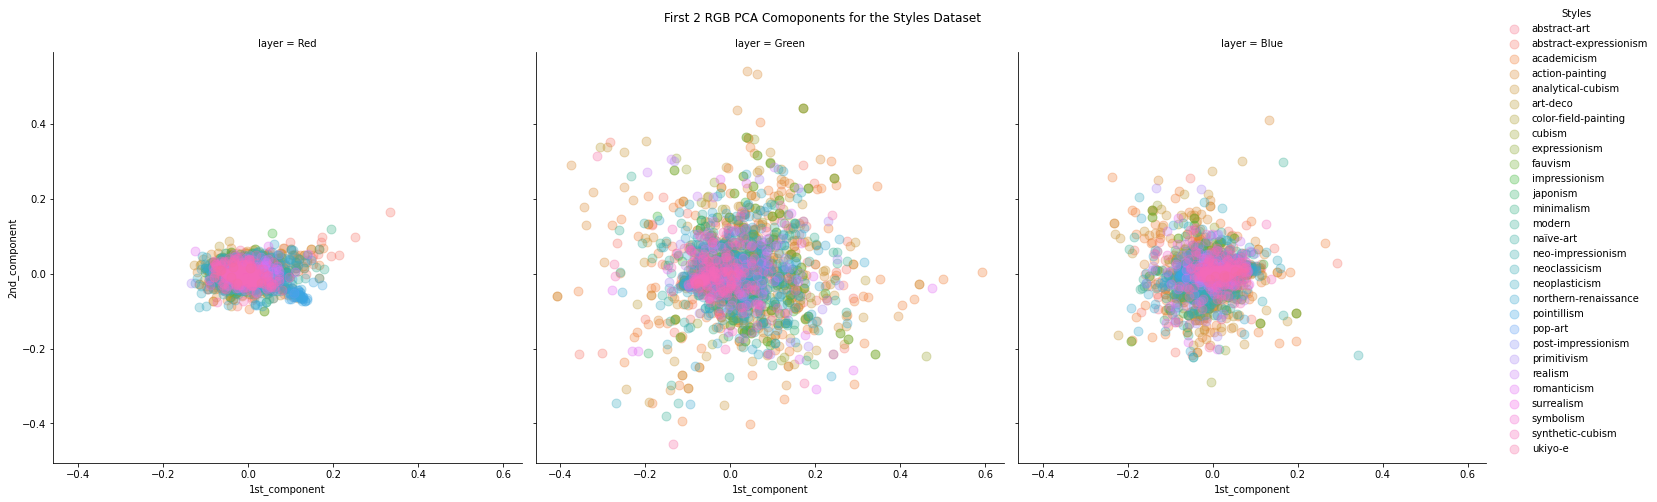

In [45]:
# combined artists pcs plots for r, g & b
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = styles, title = "Styles")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 RGB PCA Comoponents for the Styles Dataset')

# view the plots
plt.show()

## Plot the First 2 __H, L, S__  Components of each Style

In [46]:
# get the colour data
style_hue_data, style_luminance_data, style_saturation_data = read_data(PALETTES, TRAIN, STYLE, DATA, HLS)

In [47]:
# create colour pcs_datasets
pca_style_h_dataset = create_pca_2_component_dataset(style_hue_data,        read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))
pca_style_l_dataset = create_pca_2_component_dataset(style_luminance_data,  read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))
pca_style_s_dataset = create_pca_2_component_dataset(style_saturation_data, read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))

# populate layer column
pca_style_h_dataset["layer"] = "Hue"
pca_style_l_dataset["layer"] = "Luminance"
pca_style_s_dataset["layer"] = "Saturation"

# construct the plot dataset
plot_data = pca_style_h_dataset
plot_data = plot_data.append(pca_style_l_dataset)
plot_data = plot_data.append(pca_style_s_dataset)

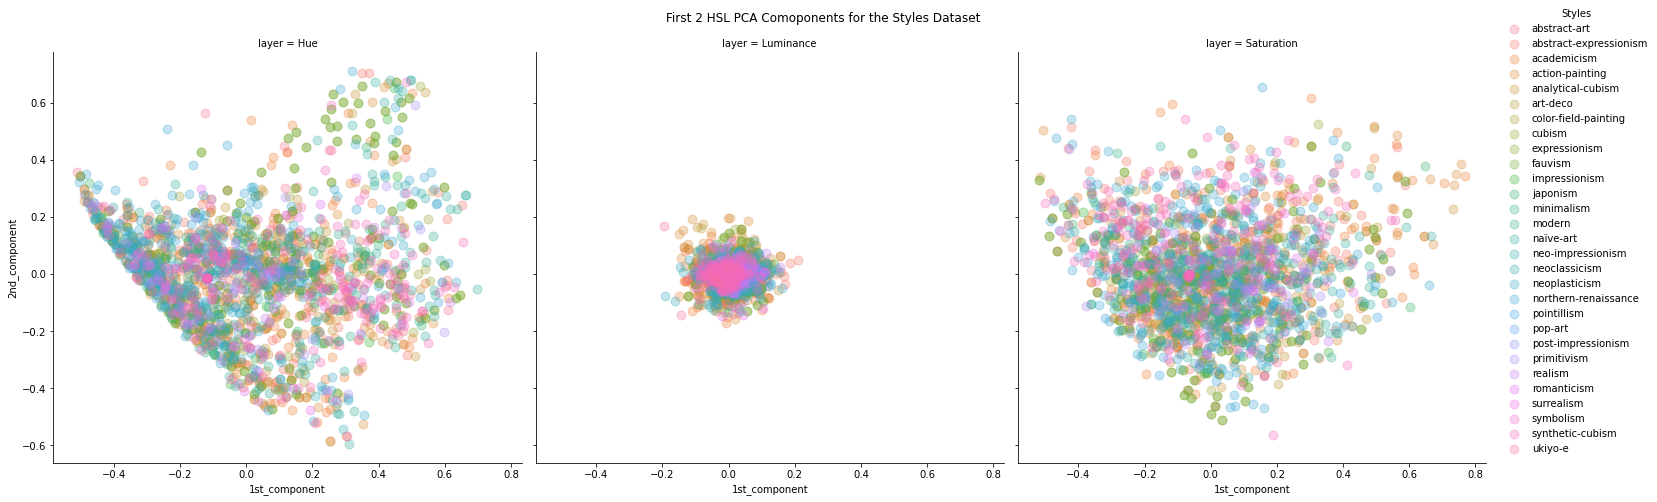

In [48]:
# combined artists pcs plots for h, l & s
fgrid = sn.FacetGrid(plot_data, hue = "label", height = 7, col="layer",).map(plt.scatter, "1st_component", "2nd_component", s = 80, alpha = 0.3).add_legend(labels = styles, title = "Styles")
fgrid.fig.subplots_adjust(top=0.9) 

# set the title for the grid
fgrid.fig.suptitle('First 2 HSL PCA Comoponents for the Styles Dataset')

# view the plots
plt.show()

That is a little hard to read. So, let´s try viewing the data by individual Styles. 

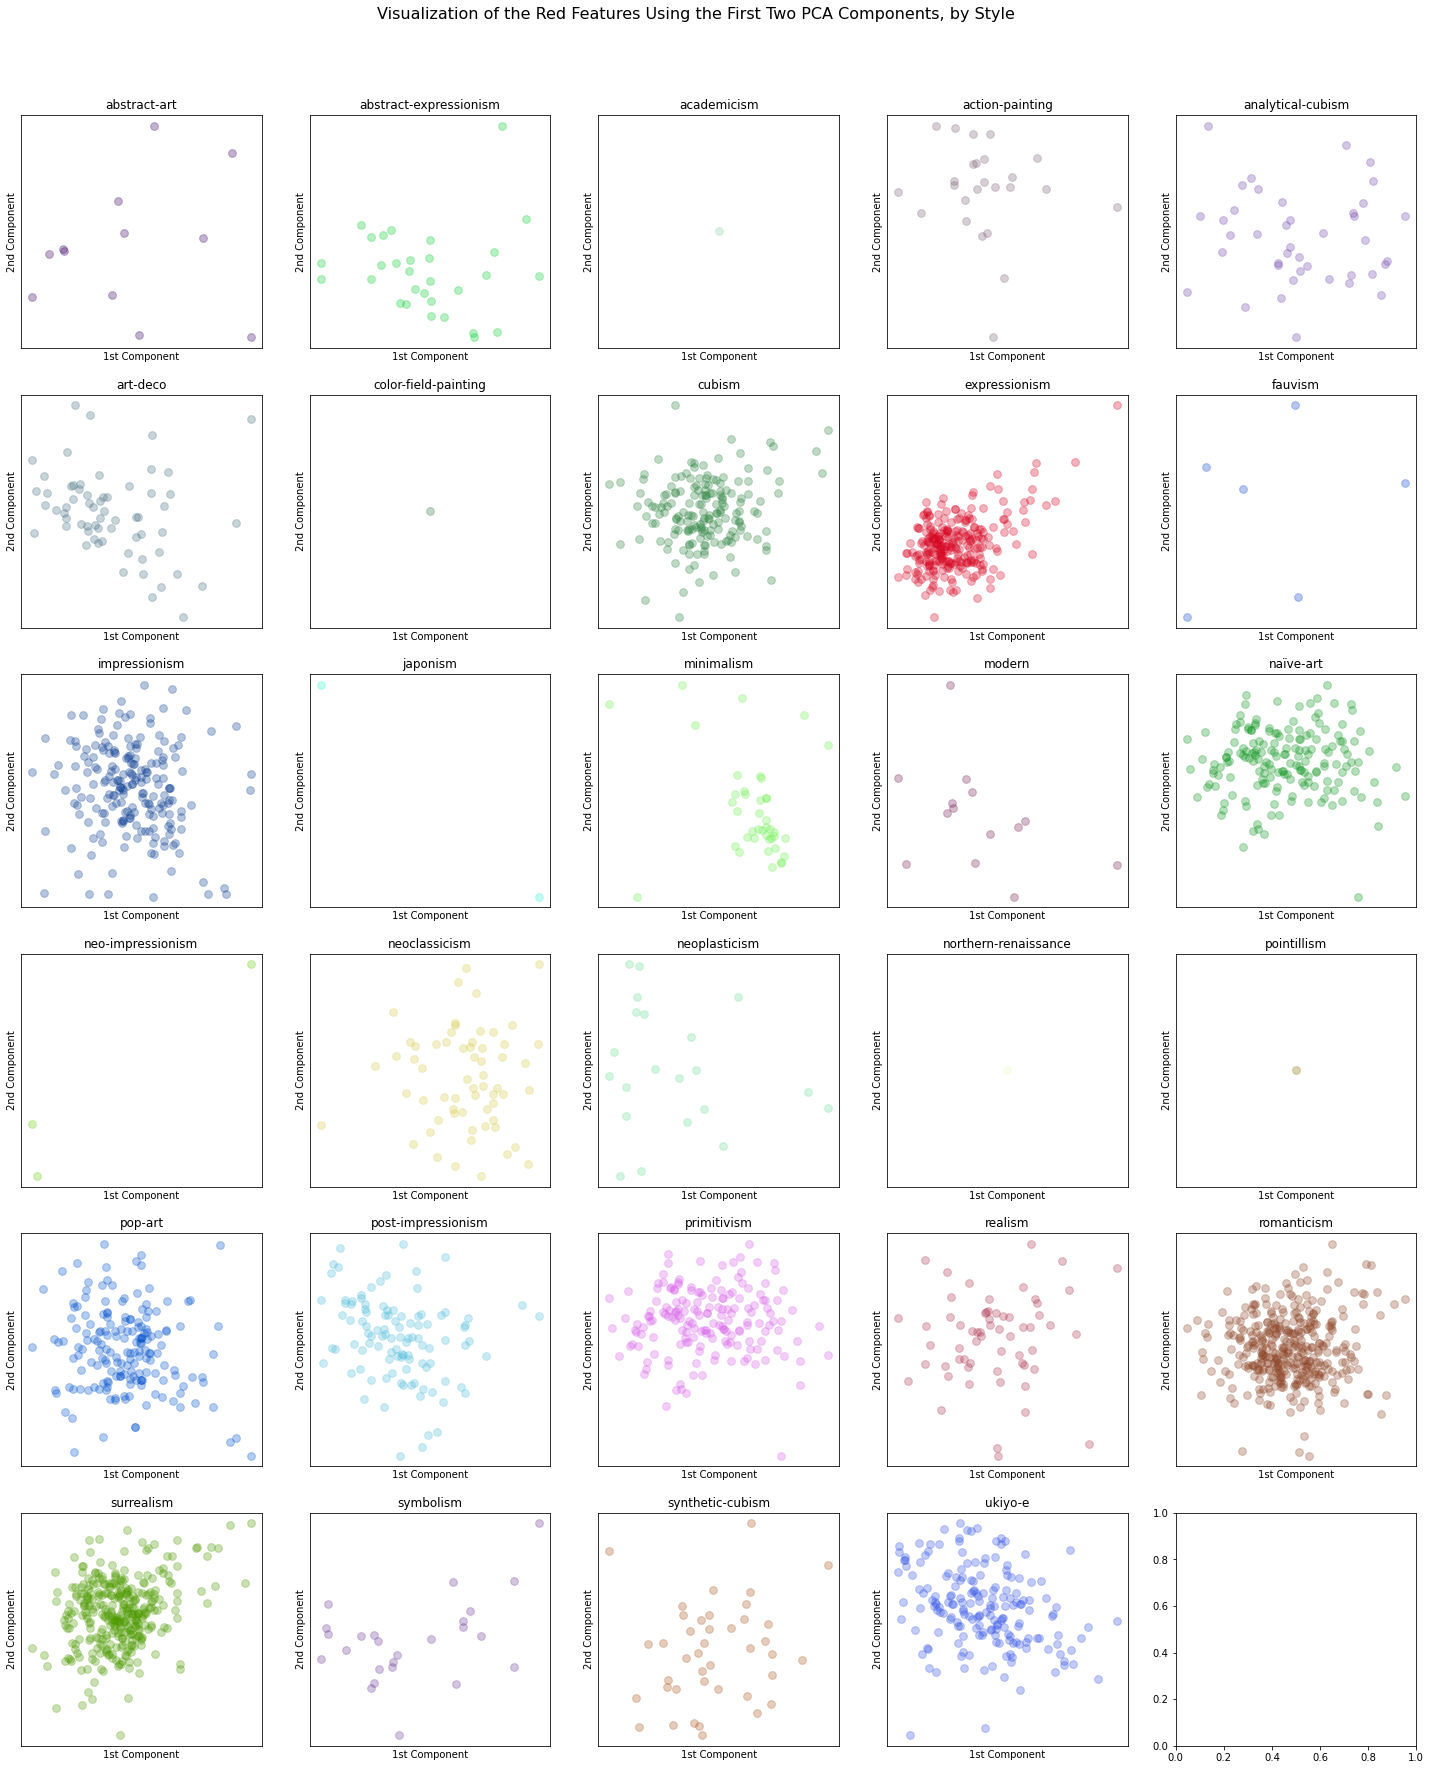

In [49]:
grid_target_components(pca_style_r_dataset, styles, "Visualization of the Red Features Using the First Two PCA Components, by Style")

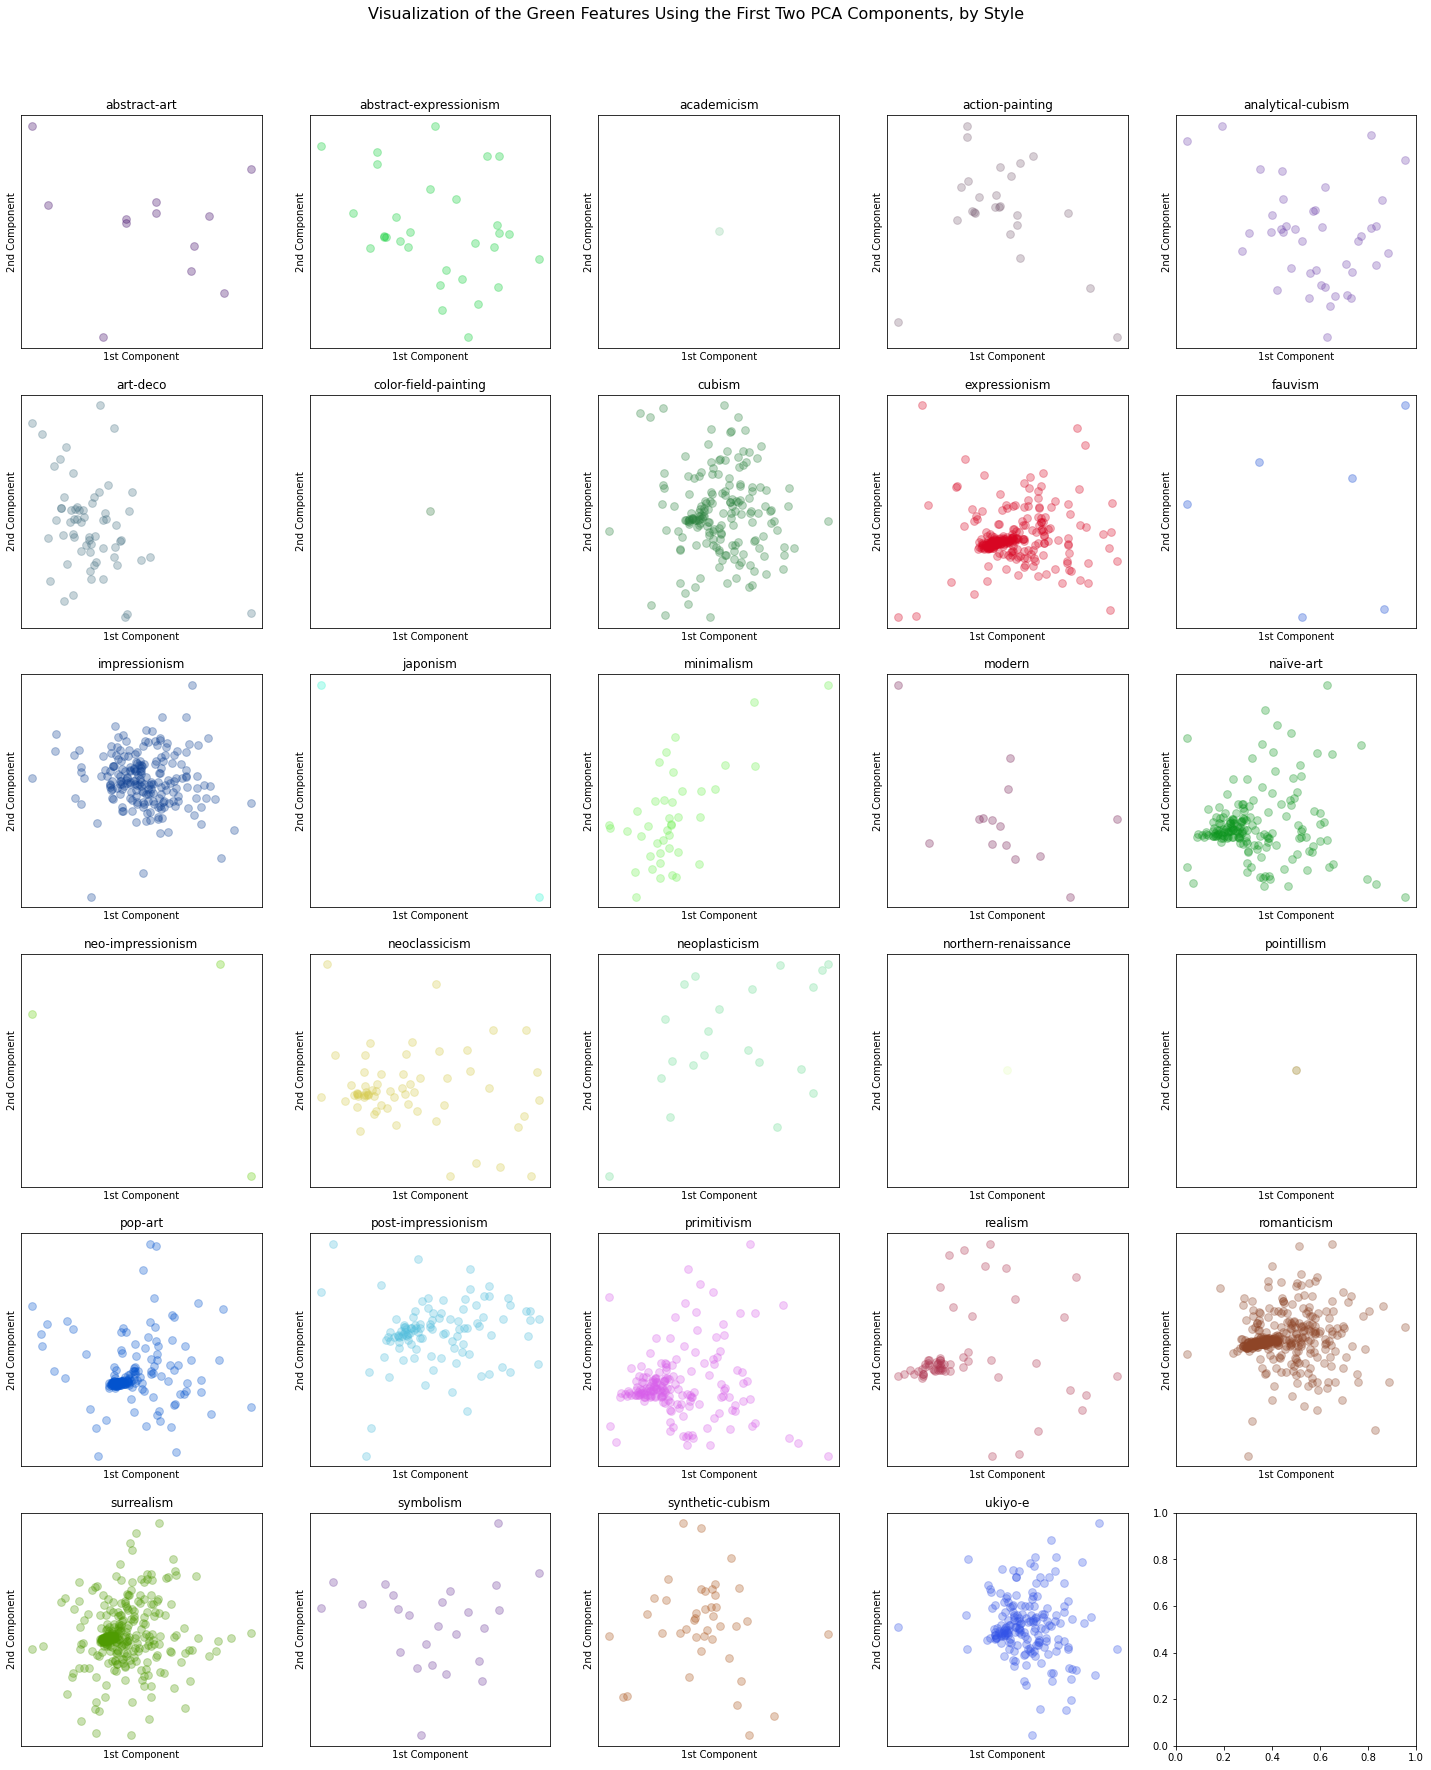

In [50]:
grid_target_components(pca_style_g_dataset, styles, "Visualization of the Green Features Using the First Two PCA Components, by Style")

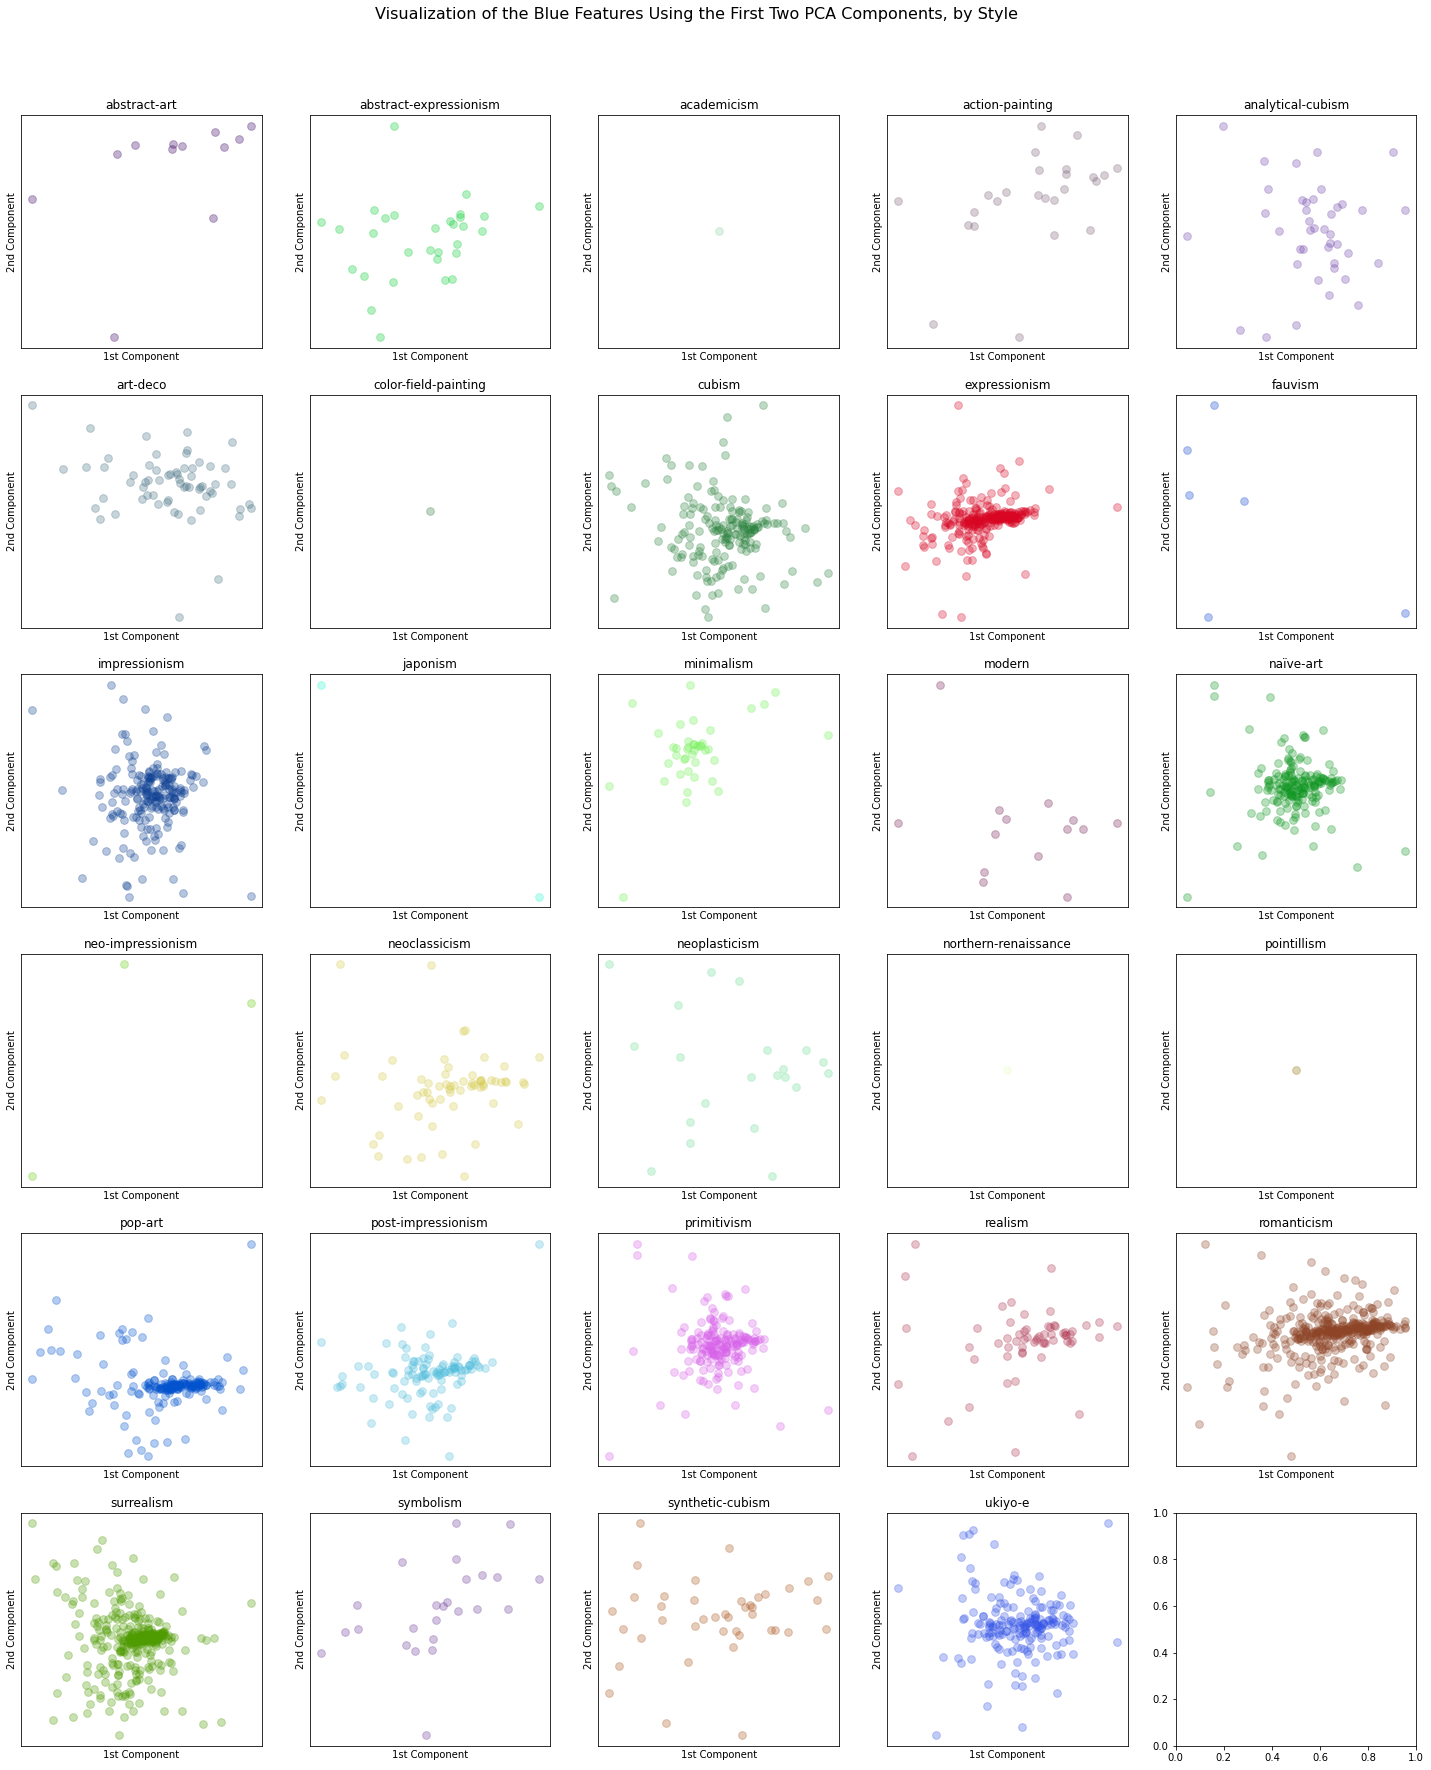

In [51]:
grid_target_components(pca_style_b_dataset, styles, "Visualization of the Blue Features Using the First Two PCA Components, by Style")

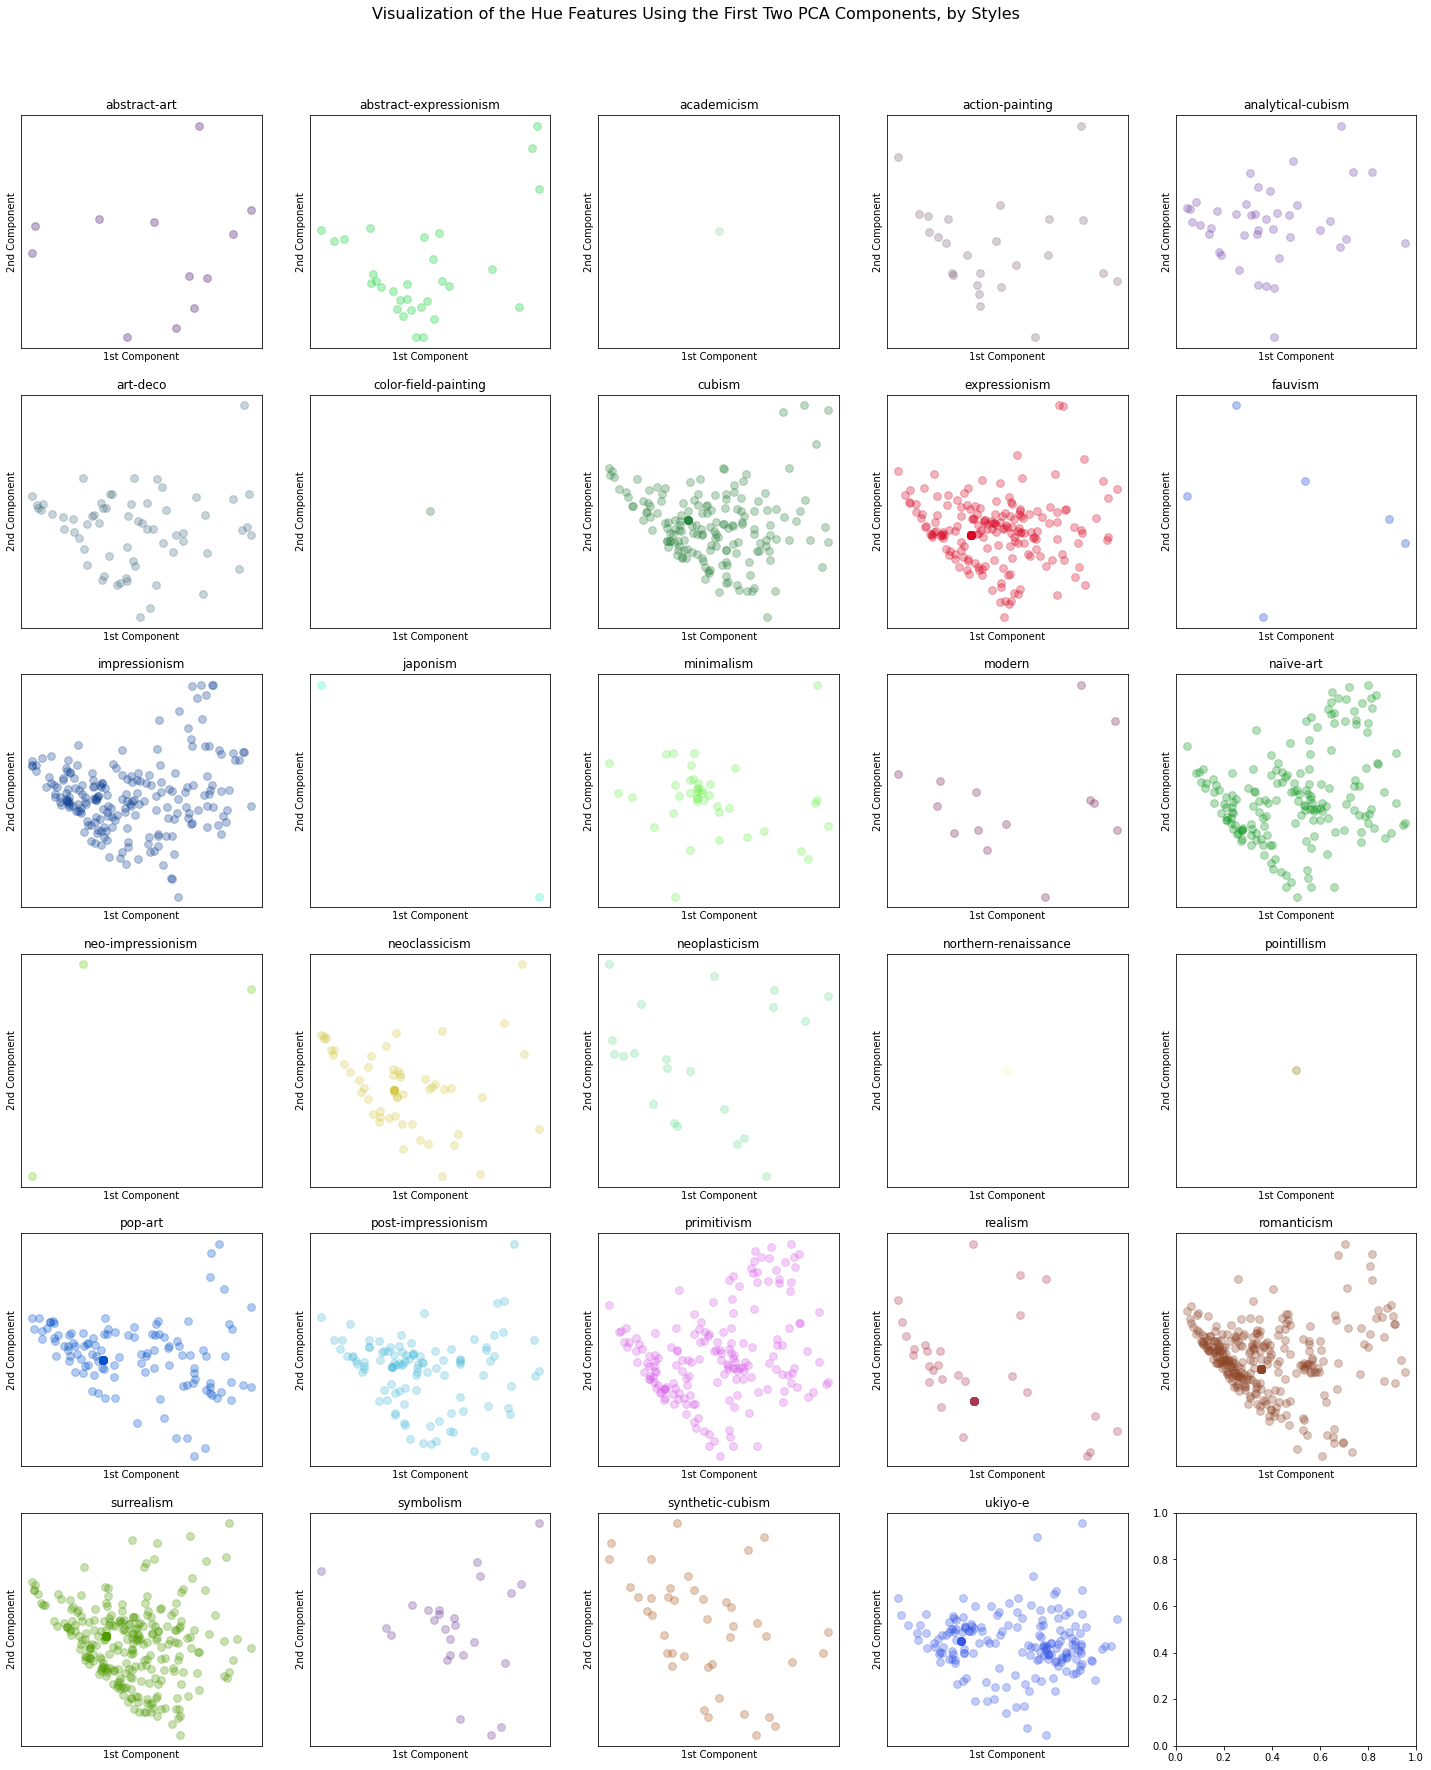

In [52]:
grid_target_components(pca_style_h_dataset, styles, "Visualization of the Hue Features Using the First Two PCA Components, by Styles")

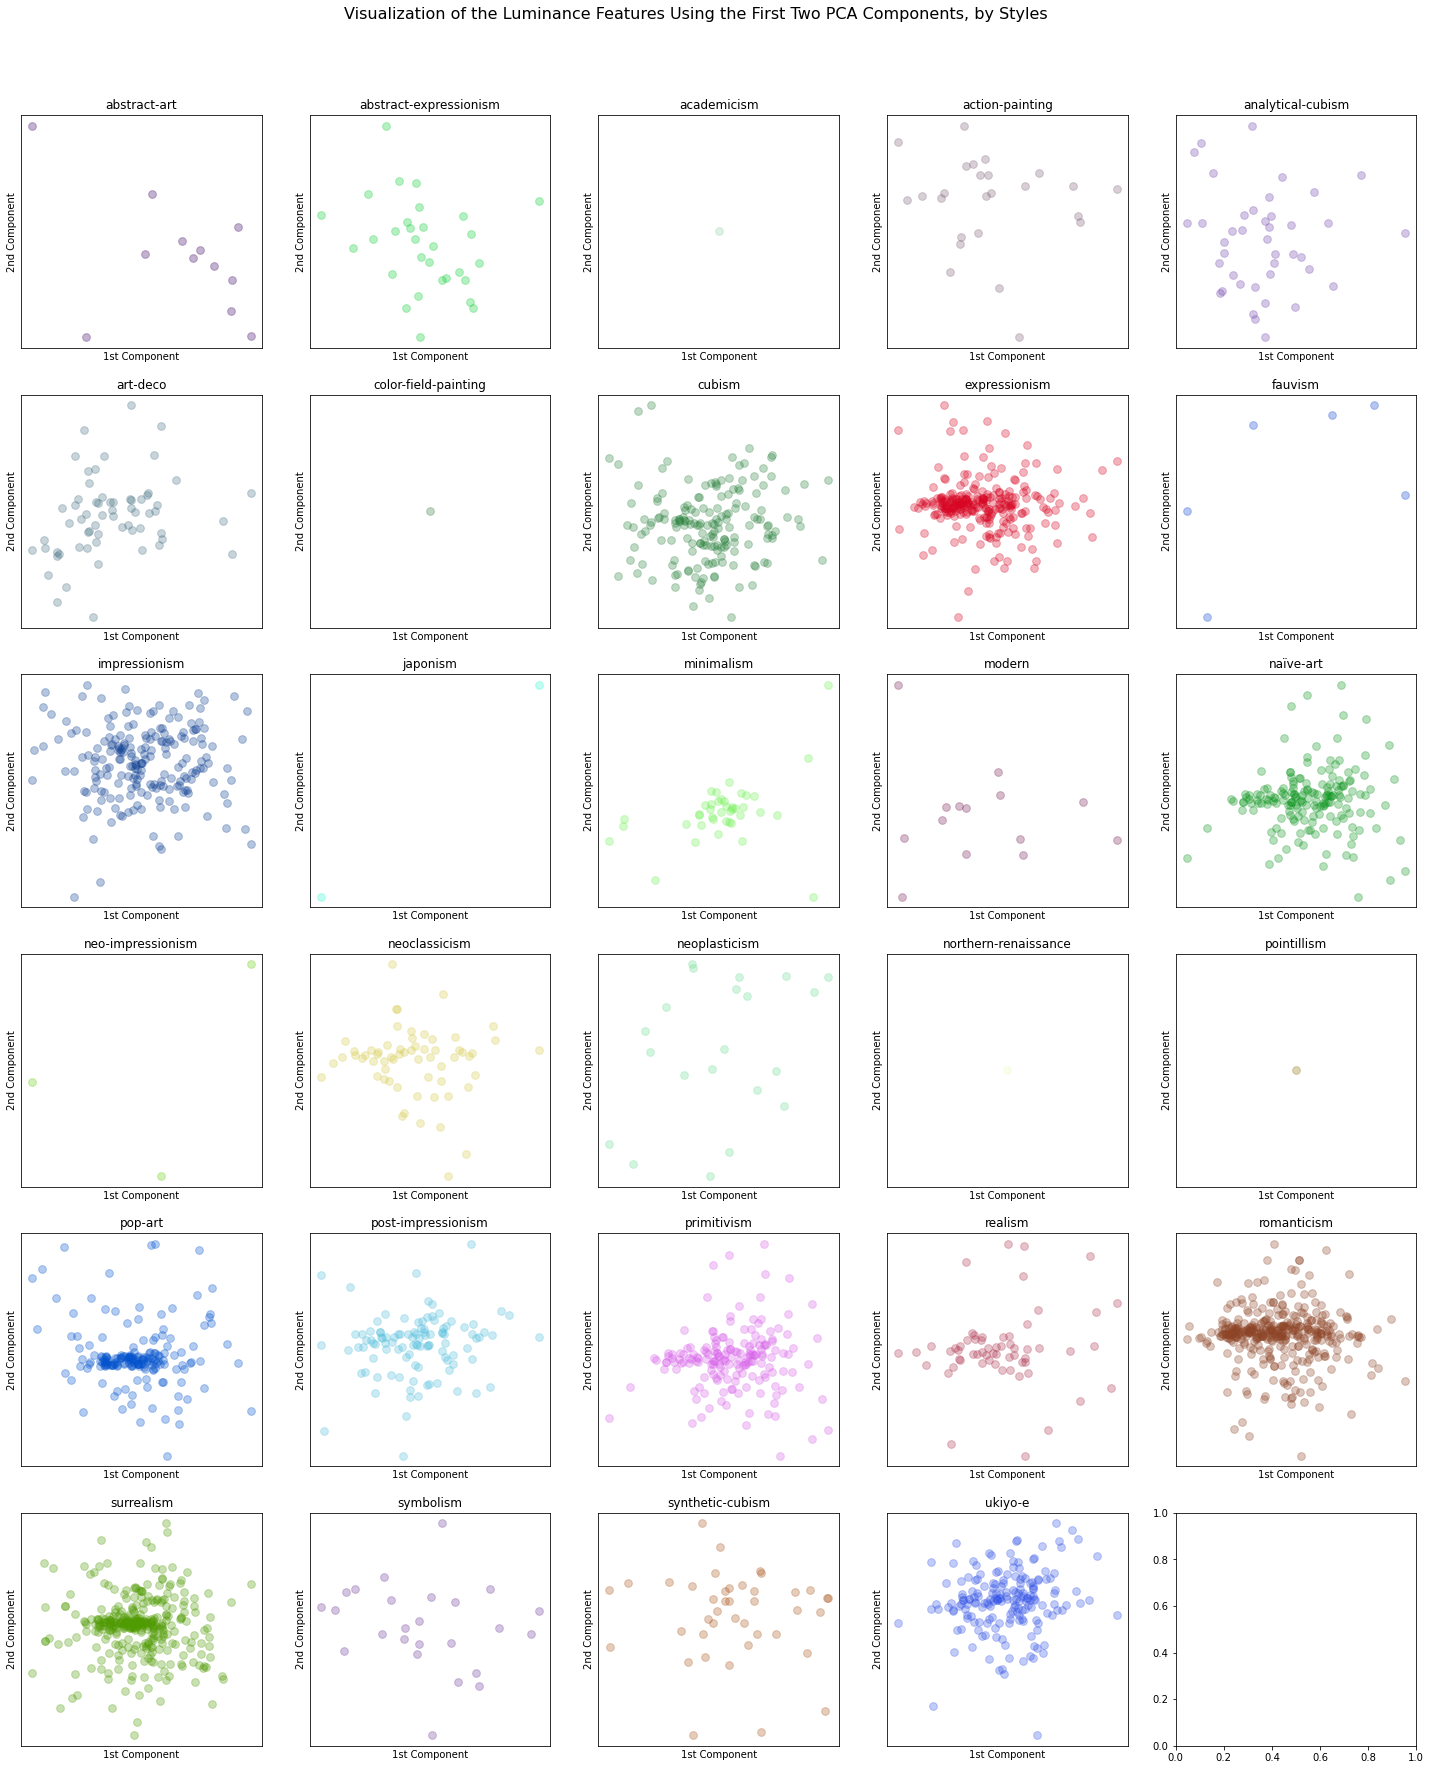

In [53]:
grid_target_components(pca_style_l_dataset, styles, "Visualization of the Luminance Features Using the First Two PCA Components, by Styles")

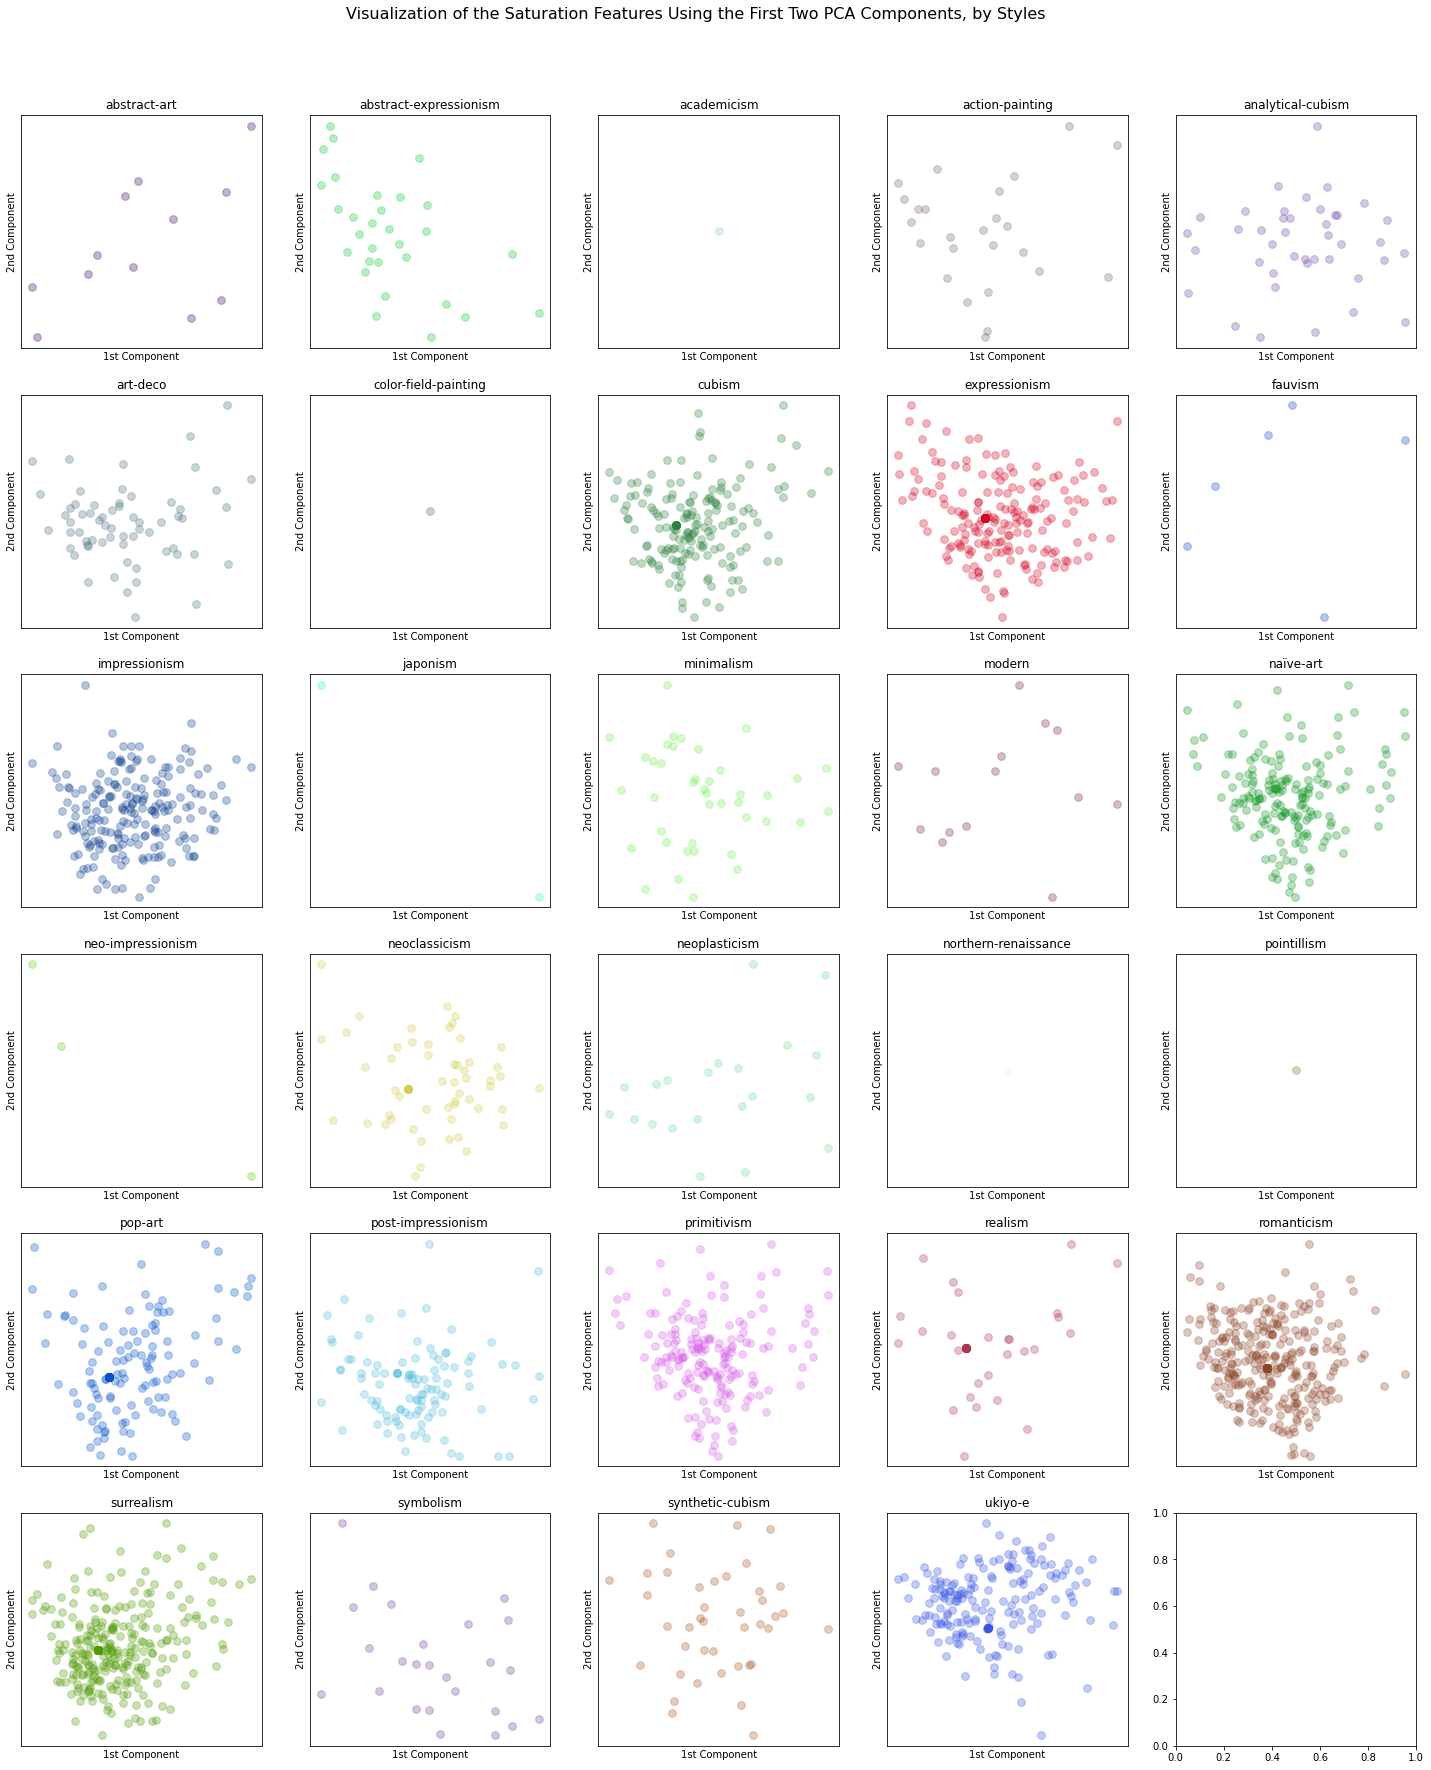

In [54]:
grid_target_components(pca_style_s_dataset, styles, "Visualization of the Saturation Features Using the First Two PCA Components, by Styles")

__NOTE:__ the section below requires _ipwidgets_ to be enabled to function correctly. 

## Plot the First 3 Palatte Components for Selected Artist
__NOTE:__ Check the Artist whos data you wish to view and the click the <code>Replot</code> button. You can rotate the plot by adjusting the _Azimut_ slider and then click the <code>Replot</code> button.

In [55]:
channel_data = {"Red"        : create_pca_3_component_dataset(artist_red_data,        read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY)),
                "Green"      : create_pca_3_component_dataset(artist_green_data,      read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY)),
                "Blue"       : create_pca_3_component_dataset(artist_blue_data,       read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY)),
                "Hue"        : create_pca_3_component_dataset(artist_hue_data,        read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY)),
                "Luminance"  : create_pca_3_component_dataset(artist_luminance_data,  read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY)),
                "Saturation" : create_pca_3_component_dataset(artist_saturation_data, read_data(PALETTES, TRAIN, ARTIST, CATAGORY_NUM), read_data(PALETTES, TRAIN, ARTIST, CATAGORY))}

In [56]:
plot_3d_target_components(channel_data, artists)

## Plot the First 3 Palatte Components for Selected Genre
__NOTE:__ Check the Genre whos data you wish to view and the click the <code>Replot</code> button. You can rotate the plot by adjusting the _Azimut_ slider and then click the <code>Replot</code> button.

In [57]:
channel_data = {"Red"        : create_pca_3_component_dataset(genre_red_data,        read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY)),
                "Green"      : create_pca_3_component_dataset(genre_green_data,      read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY)),
                "Blue"       : create_pca_3_component_dataset(genre_blue_data,       read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY)),
                "Hue"        : create_pca_3_component_dataset(genre_hue_data,        read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY)),
                "Luminance"  : create_pca_3_component_dataset(genre_luminance_data,  read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY)),
                "Saturation" : create_pca_3_component_dataset(genre_saturation_data, read_data(PALETTES, TRAIN, GENRE, CATAGORY_NUM), read_data(PALETTES, TRAIN, GENRE, CATAGORY))}

In [58]:
plot_3d_target_components(channel_data, genres)

## Plot the First 3 Palatte Components for Selected Style
__NOTE:__ Check the Style whos data you wish to view and the click the <code>Replot</code> button. You can rotate the plot by adjusting the _Azimut_ slider and then click the <code>Replot</code> button.

In [59]:
channel_data = {"Red"        : create_pca_3_component_dataset(style_red_data,        read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY)),
                "Green"      : create_pca_3_component_dataset(style_green_data,      read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY)),
                "Blue"       : create_pca_3_component_dataset(style_blue_data,       read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY)),
                "Hue"        : create_pca_3_component_dataset(style_hue_data,        read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY)),
                "Luminance"  : create_pca_3_component_dataset(style_luminance_data,  read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY)),
                "Saturation" : create_pca_3_component_dataset(style_saturation_data, read_data(PALETTES, TRAIN, STYLE, CATAGORY_NUM), read_data(PALETTES, TRAIN, STYLE, CATAGORY))}

In [60]:
plot_3d_target_components(channel_data, styles)

## Comment
We see that although there are some difference between the different plots. There is a great deal of overlap. Suggesting the 16 colour palette data may not be a good data set to differentiate any of the targets __ARTIST__, __GENRE__ or __STYLE__.